In [7]:
import sys
import os
import numpy as np
import pandas as pd

import h5py

import matplotlib.pyplot as plt

from scipy.stats import spearmanr, pearsonr

from scipy.ndimage import gaussian_filter1d

import seaborn as sns

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

#Helper function to draw a letter at a given position
def dna_letter_at(letter, x, y, yscale=1, ax=None, color=None, alpha=1.0):

    #Define letter heights and colors
    fp = FontProperties(family="DejaVu Sans", weight="bold")
    globscale = 1.35
    LETTERS = {	"T" : TextPath((-0.305, 0), "T", size=1, prop=fp),
                "G" : TextPath((-0.384, 0), "G", size=1, prop=fp),
                "A" : TextPath((-0.35, 0), "A", size=1, prop=fp),
                "C" : TextPath((-0.366, 0), "C", size=1, prop=fp),
                "UP" : TextPath((-0.488, 0), '$\\Uparrow$', size=1, prop=fp),
                "DN" : TextPath((-0.488, 0), '$\\Downarrow$', size=1, prop=fp),
                "(" : TextPath((-0.25, 0), "(", size=1, prop=fp),
                "." : TextPath((-0.125, 0), "-", size=1, prop=fp),
                ")" : TextPath((-0.1, 0), ")", size=1, prop=fp)}
    COLOR_SCHEME = {'G': 'orange',#'orange', 
                    'A': 'green',#'red', 
                    'C': 'blue',#'blue', 
                    'T': 'red',#'darkgreen',
                    'UP': 'green', 
                    'DN': 'red',
                    '(': 'black',
                    '.': 'black', 
                    ')': 'black'}


    text = LETTERS[letter]

    #Choose color
    chosen_color = COLOR_SCHEME[letter]
    if color is not None :
        chosen_color = color

    #Draw letter onto axis
    t = mpl.transforms.Affine2D().scale(1*globscale, yscale*globscale) + \
        mpl.transforms.Affine2D().translate(x,y) + ax.transData
    p = PathPatch(text, lw=0, fc=chosen_color, alpha=alpha, transform=t)
    if ax != None:
        ax.add_artist(p)
    
    return p

#Function to plot sequence logo
def plot_seq_scores(importance_scores, figsize=(16, 2), plot_y_ticks=True, y_min=None, y_max=None, save_figs=False, fig_name="default") :

    importance_scores = importance_scores.T

    fig = plt.figure(figsize=figsize)
    
    ref_seq = ""
    
    #Loop over reference sequence letters
    for j in range(importance_scores.shape[1]) :
        argmax_nt = np.argmax(np.abs(importance_scores[:, j]))
        
        if argmax_nt == 0 :
            ref_seq += "A"
        elif argmax_nt == 1 :
            ref_seq += "C"
        elif argmax_nt == 2 :
            ref_seq += "G"
        elif argmax_nt == 3 :
            ref_seq += "T"

    ax = plt.gca()
    
    #Loop over reference sequence letters and draw
    for i in range(0, len(ref_seq)) :
        mutability_score = np.sum(importance_scores[:, i])
        color = None
        dna_letter_at(ref_seq[i], i + 0.5, 0, mutability_score, ax, color=color)
    
    plt.sca(ax)
    plt.xticks([], [])
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    
    plt.xlim((0, len(ref_seq)))
    
    #plt.axis('off')
    
    if plot_y_ticks :
        plt.yticks(fontsize=12)
    else :
        plt.yticks([], [])
    
    #Set axis limits
    if y_min is not None and y_max is not None :
        print(" - y_min = " + str(round(y_min, 8)))
        print(" - y_max = " + str(round(y_max, 8)))
        
        plt.ylim(y_min, y_max)
    elif y_min is not None :
        plt.ylim(y_min)
    else :
        print(" - y_min = " + str(round(np.min(importance_scores) - 0.1 * np.max(np.abs(importance_scores)), 8)))
        print(" - y_max = " + str(round(np.max(importance_scores) + 0.1 * np.max(np.abs(importance_scores)), 8)))
        
        plt.ylim(
            np.min(importance_scores) - 0.1 * np.max(np.abs(importance_scores)),
            np.max(importance_scores) + 0.1 * np.max(np.abs(importance_scores))
        )
    
    plt.axhline(y=0., color='black', linestyle='-', linewidth=1)

    #for axis in fig.axes :
    #    axis.get_xaxis().set_visible(False)
    #    axis.get_yaxis().set_visible(False)

    plt.tight_layout()

    if save_figs :
        plt.savefig(fig_name + ".png", transparent=True, dpi=300)
        plt.savefig(fig_name + ".eps")

    plt.show()


In [2]:
#Load gene dataframe and select tissue

tissue = 'blood'

top_n = 200

gene_df = pd.read_csv("/home/jlinder/seqnn/data/diff_expr/gtex_diff_expr_log2fc_5k.csv", sep='\t')
gene_df = gene_df.query("tissue == '" + str(tissue) + "'").copy().reset_index(drop=True)
gene_df = gene_df.drop(columns=['Unnamed: 0'])

#Select top N
gene_df = gene_df.iloc[:top_n].copy().reset_index(drop=True)

print("len(gene_df) = " + str(len(gene_df)))

#Get list of gene for tissue
tissue_genes = gene_df['gene_base'].values.tolist()

print("len(tissue_genes) = " + str(len(tissue_genes)))


len(gene_df) = 200
len(tissue_genes) = 200


In [3]:
#Load ISMs for the selected set of GTEx tissues

import gc

gtex_tissues = ['blood', 'brain', 'esophagus', 'liver', 'muscle']
gtex_tissue_targets = [[0], [1], [2], [3], [4]]
gtex_h5s = [
    'scores_v2/gtex_blood_log2fc_ism_aggr_f0c0.h5',
    'scores_v2/gtex_blood_log2fc_ism_aggr_f0c0.h5',
    'scores_v2/gtex_blood_log2fc_ism_aggr_f0c0.h5',
    'scores_v2/gtex_blood_log2fc_ism_aggr_f0c0.h5',
    'scores_v2/gtex_blood_log2fc_ism_aggr_f0c0.h5',
]

ism_seqs = None
ism_starts = None
ism_ends = None

all_isms = []

#Loop over h5 score files
for gtex_i, gtex_h5 in enumerate(gtex_h5s) :
    
    print("h5 = '" + gtex_h5 + "'")

    score_file = h5py.File(gtex_h5, 'r')

    #Get scores and onehots
    isms = np.mean(score_file['isms'][()][..., gtex_tissue_targets[gtex_i]], axis=-1)
    ism_seqs = score_file['seqs'][()]

    ism_starts = np.array(score_file['ism_start'][()])
    ism_ends = np.array(score_file['ism_end'][()])

    genes = score_file['gene'][()]
    genes = np.array([genes[j].decode().split(".")[0] for j in range(genes.shape[0])])
    
    gene_dict = {gene : gene_i for gene_i, gene in enumerate(genes.tolist())}

    #Get index of rows to keep
    keep_index = []
    for tissue_gene in tissue_genes :
        keep_index.append(gene_dict[tissue_gene])

    #Filter/sub-select data
    isms = isms[keep_index, ...]
    ism_seqs = ism_seqs[keep_index, ...]
    ism_starts = ism_starts[keep_index]
    ism_ends = ism_ends[keep_index]

    #Input-gate the scores
    isms = isms * ism_seqs
    
    all_isms.append(isms[None, ...])

    #Collect garbage
    gc.collect()

#Collect final scores
isms = np.concatenate(all_isms, axis=0)

print("isms.shape = " + str(isms.shape) + " (final)")

score_file = None

#Collect garbage
gc.collect()


h5 = 'scores_v2/gtex_blood_log2fc_ism_aggr_f0c0.h5'
h5 = 'scores_v2/gtex_blood_log2fc_ism_aggr_f0c0.h5'
h5 = 'scores_v2/gtex_blood_log2fc_ism_aggr_f0c0.h5'
h5 = 'scores_v2/gtex_blood_log2fc_ism_aggr_f0c0.h5'
h5 = 'scores_v2/gtex_blood_log2fc_ism_aggr_f0c0.h5'
isms.shape = (5, 200, 192, 4) (final)


0

In [4]:
#Load grad scores for the selected set of GTEx tissues

import gc

gtex_tissues = ['blood', 'brain', 'esophagus', 'liver', 'muscle']
gtex_h5s = [
    'scores_v2/gtex_blood_log2fc_undo_clip_scores_f0c0.h5',
    'scores_v2/gtex_brain_log2fc_undo_clip_scores_f0c0.h5',
    'scores_v2/gtex_esophagus_log2fc_undo_clip_scores_f0c0.h5',
    'scores_v2/gtex_liver_log2fc_undo_clip_scores_f0c0.h5',
    'scores_v2/gtex_muscle_log2fc_undo_clip_scores_f0c0.h5',
]

seqs = None
strands = None
chrs = None
starts = None
ends = None
genes = None

all_scores = []

#Loop over h5 score files
for gtex_h5 in gtex_h5s :
    
    print("h5 = '" + gtex_h5 + "'")

    score_file = h5py.File(gtex_h5, 'r')

    #Get scores and onehots
    scores = score_file['grads'][()][..., 0]
    seqs = score_file['seqs'][()]

    #Get auxiliary information
    strands = score_file['strand'][()]
    strands = np.array([strands[j].decode() for j in range(strands.shape[0])])

    chrs = score_file['chr'][()]
    chrs = np.array([chrs[j].decode() for j in range(chrs.shape[0])])

    starts = np.array(score_file['start'][()])
    ends = np.array(score_file['end'][()])

    genes = score_file['gene'][()]
    genes = np.array([genes[j].decode().split(".")[0] for j in range(genes.shape[0])])
    
    gene_dict = {gene : gene_i for gene_i, gene in enumerate(genes.tolist())}

    #Get index of rows to keep
    keep_index = []
    for tissue_gene in tissue_genes :
        keep_index.append(gene_dict[tissue_gene])

    #Filter/sub-select data
    scores = scores[keep_index, ...]
    seqs = seqs[keep_index, ...]
    strands = strands[keep_index]
    chrs = chrs[keep_index]
    starts = starts[keep_index]
    ends = ends[keep_index]
    genes = genes[keep_index]

    #Input-gate the scores
    scores = scores * seqs
    
    #Slice out same window as ISMs were computed over
    scores_new = np.zeros((scores.shape[0], ism_ends[0]-ism_starts[0], 4))
    seqs_new = np.zeros((scores.shape[0], ism_ends[0]-ism_starts[0], 4), dtype=bool)
    for gi in range(scores.shape[0]) :
        scores_new[gi, ...] = scores[gi, ism_starts[gi]:ism_ends[gi], :]
        seqs_new[gi, ...] = seqs[gi, ism_starts[gi]:ism_ends[gi], :]
    
    scores = scores_new
    seqs = seqs_new
    
    all_scores.append(scores[None, ...])

    #Collect garbage
    gc.collect()

#Collect final scores
scores = np.concatenate(all_scores, axis=0)

print("scores.shape = " + str(scores.shape) + " (final)")

score_file = None

#Collect garbage
gc.collect()


h5 = 'scores_v2/gtex_blood_log2fc_undo_clip_scores_f0c0.h5'
h5 = 'scores_v2/gtex_brain_log2fc_undo_clip_scores_f0c0.h5'
h5 = 'scores_v2/gtex_esophagus_log2fc_undo_clip_scores_f0c0.h5'
h5 = 'scores_v2/gtex_liver_log2fc_undo_clip_scores_f0c0.h5'
h5 = 'scores_v2/gtex_muscle_log2fc_undo_clip_scores_f0c0.h5'
scores.shape = (5, 200, 192, 4) (final)


0

-- Example = 0 --
 - ENSG00000169877(+)
 - chr16:31266321-31790609
blood (r = 0.586)
brain (r = 0.492)
esophagus (r = 0.536)
liver (r = 0.567)
muscle (r = 0.609)


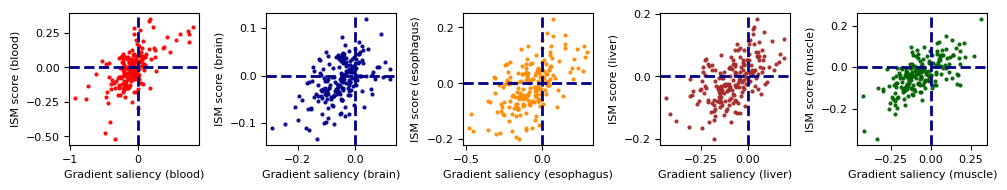

blood


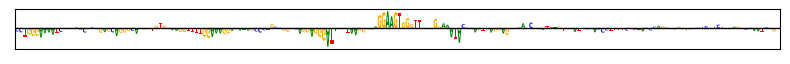

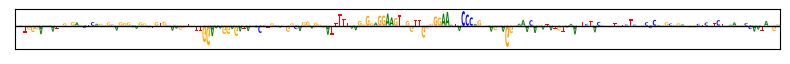

brain


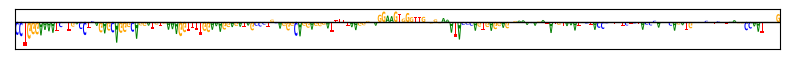

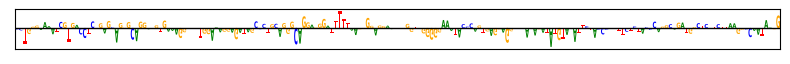

esophagus


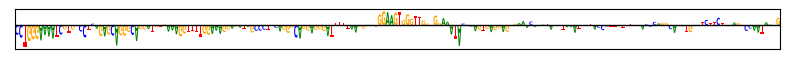

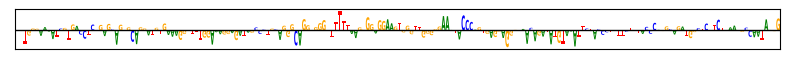

liver


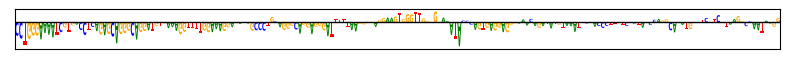

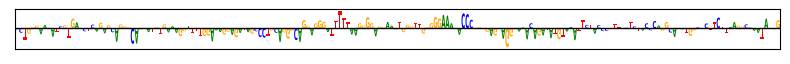

muscle


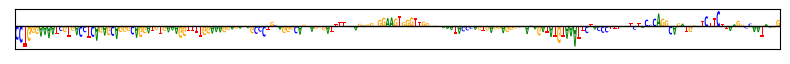

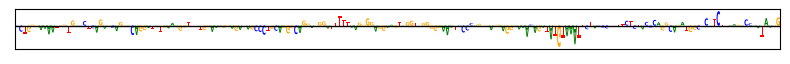

--------------------

-- Example = 1 --
 - ENSG00000206177(+)
 - chr16:-512-523776
blood (r = 0.579)
brain (r = 0.514)
esophagus (r = 0.554)
liver (r = 0.568)
muscle (r = 0.72)


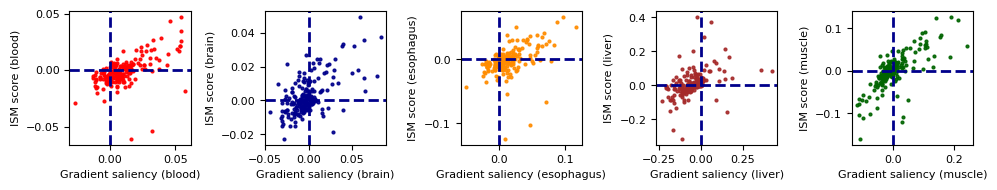

blood


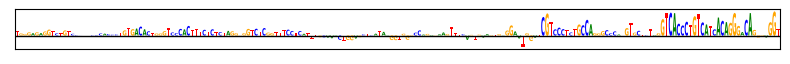

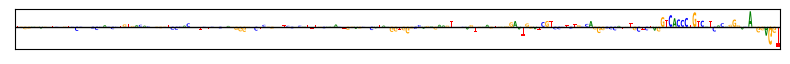

brain


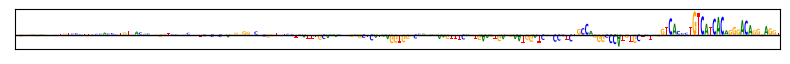

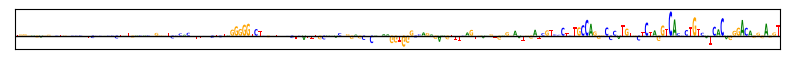

esophagus


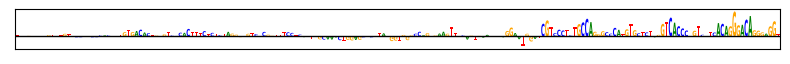

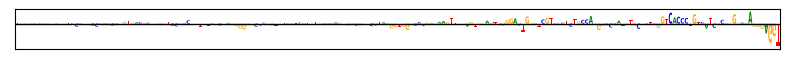

liver


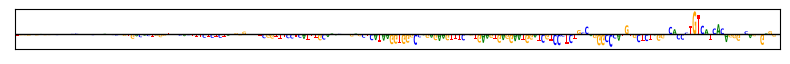

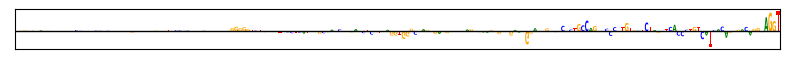

muscle


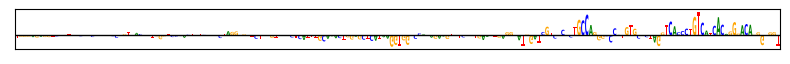

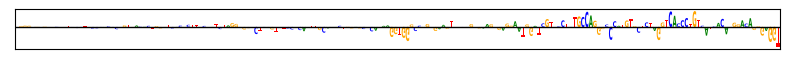

--------------------

-- Example = 2 --
 - ENSG00000118113(-)
 - chr11:102453605-102977893
blood (r = 0.77)
brain (r = 0.698)
esophagus (r = 0.731)
liver (r = 0.76)
muscle (r = 0.733)


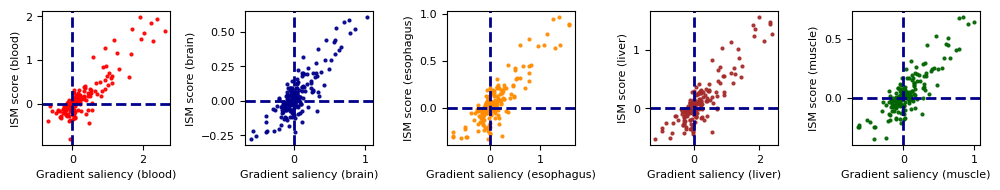

blood


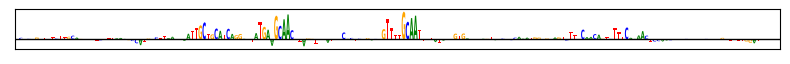

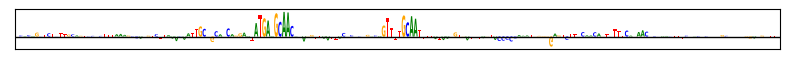

brain


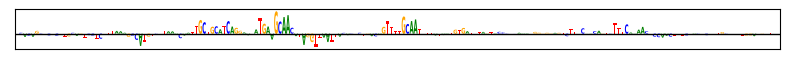

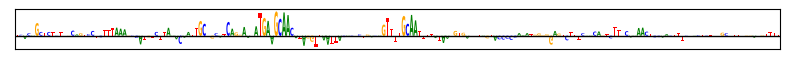

esophagus


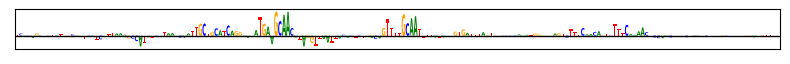

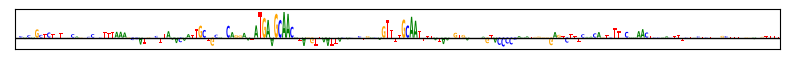

liver


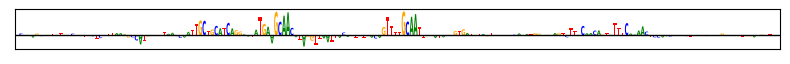

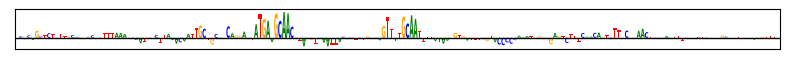

muscle


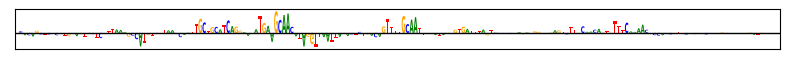

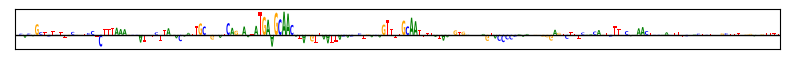

--------------------

-- Example = 3 --
 - ENSG00000110203(+)
 - chr11:71876423-72400711
blood (r = 0.704)
brain (r = 0.711)
esophagus (r = 0.737)
liver (r = 0.678)
muscle (r = 0.703)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


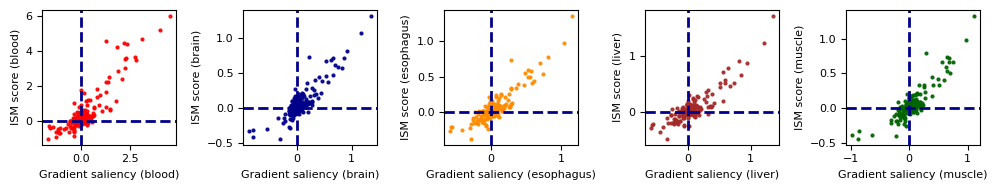

blood


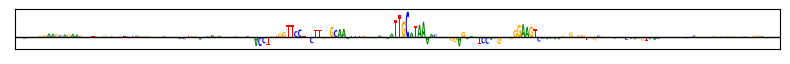

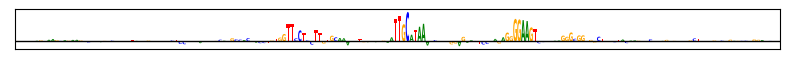

brain


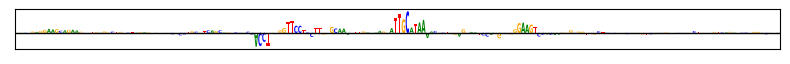

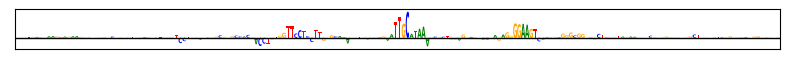

esophagus


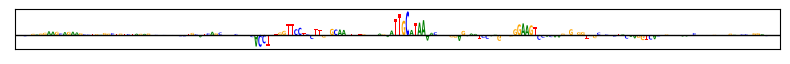

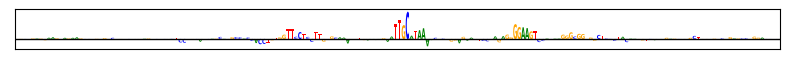

liver


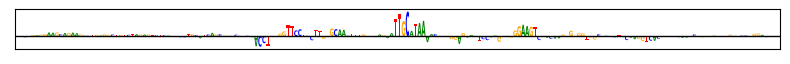

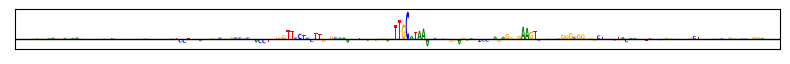

muscle


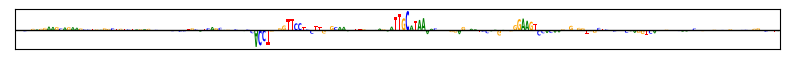

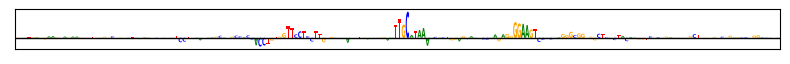

--------------------

-- Example = 4 --
 - ENSG00000126262(+)
 - chr19:35188458-35712746
blood (r = 0.662)
brain (r = 0.666)
esophagus (r = 0.701)
liver (r = 0.554)
muscle (r = 0.668)


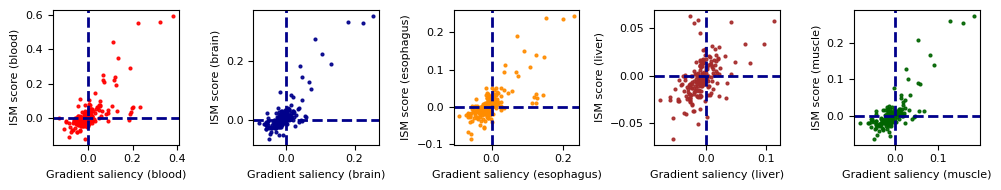

blood


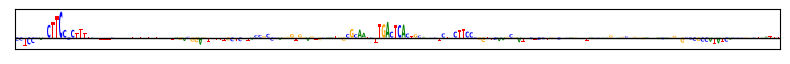

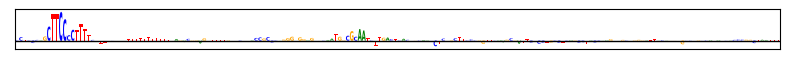

brain


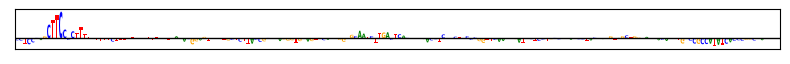

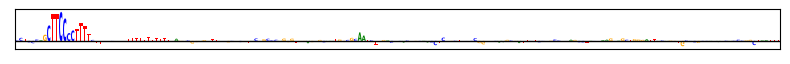

esophagus


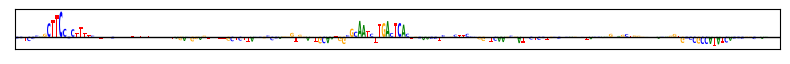

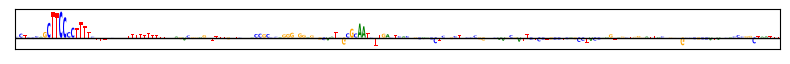

liver


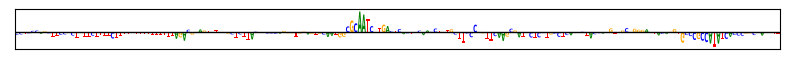

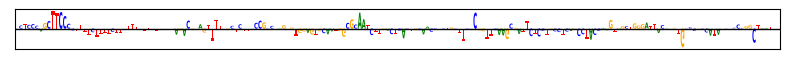

muscle


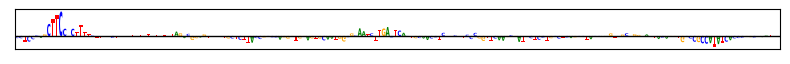

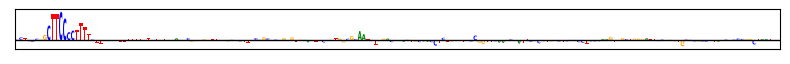

--------------------

-- Example = 5 --
 - ENSG00000004939(-)
 - chr17:43991866-44516154
blood (r = 0.655)
brain (r = 0.44)
esophagus (r = 0.761)
liver (r = 0.768)
muscle (r = 0.534)


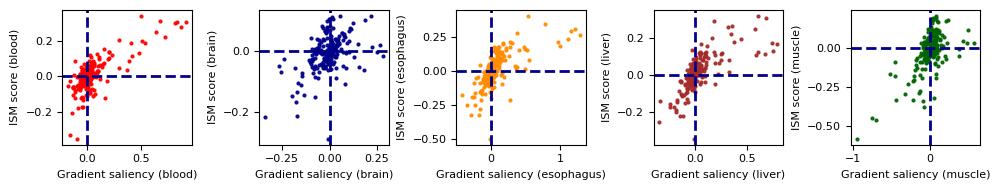

blood


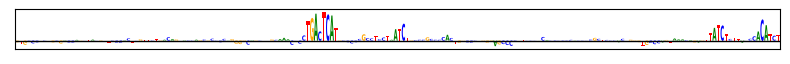

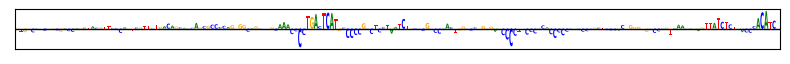

brain


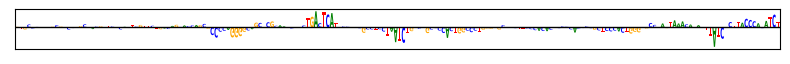

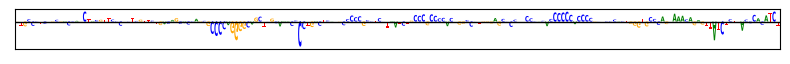

esophagus


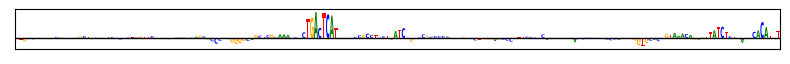

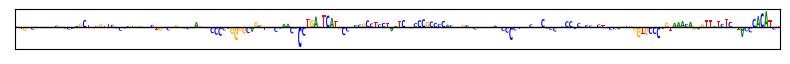

liver


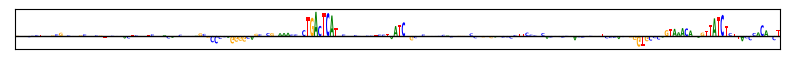

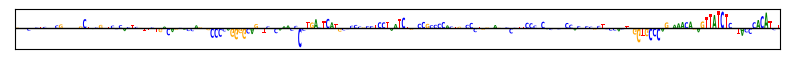

muscle


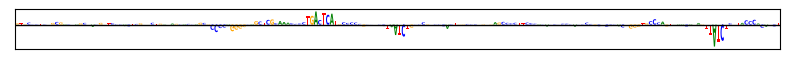

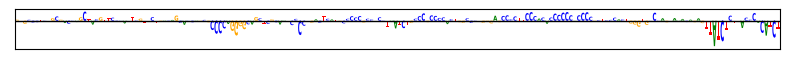

--------------------

-- Example = 6 --
 - ENSG00000171049(+)
 - chr19:51507222-52031510
blood (r = 0.724)
brain (r = 0.576)
esophagus (r = 0.713)
liver (r = 0.598)
muscle (r = 0.711)


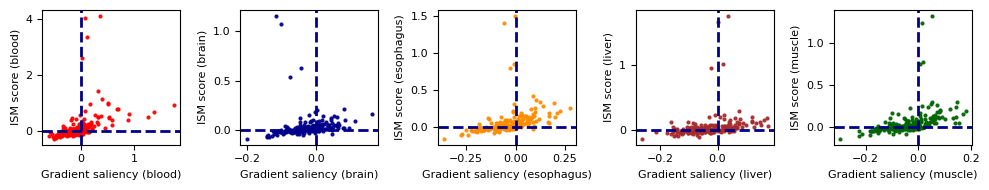

blood


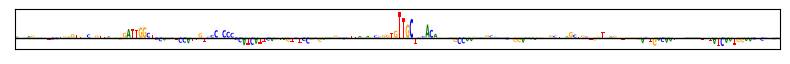

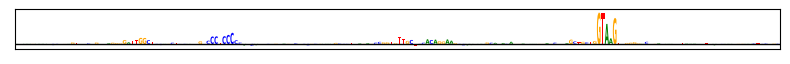

brain


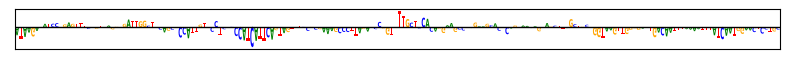

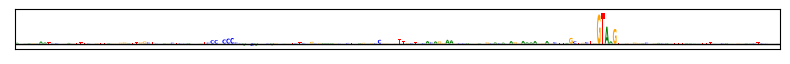

esophagus


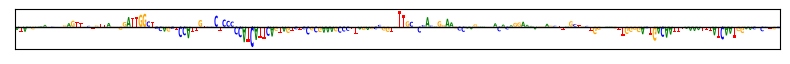

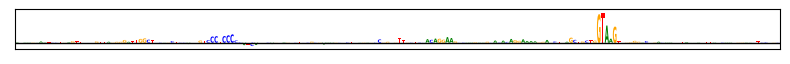

liver


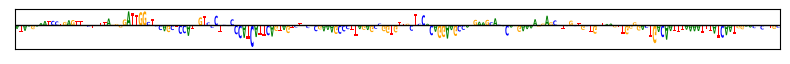

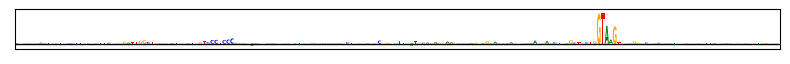

muscle


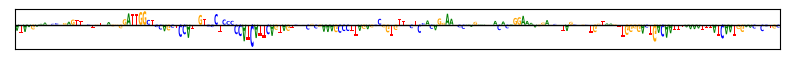

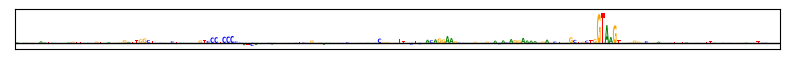

--------------------

-- Example = 7 --
 - ENSG00000180871(+)
 - chr2:217872624-218396912
blood (r = 0.676)
brain (r = 0.616)
esophagus (r = 0.734)
liver (r = 0.614)
muscle (r = 0.653)


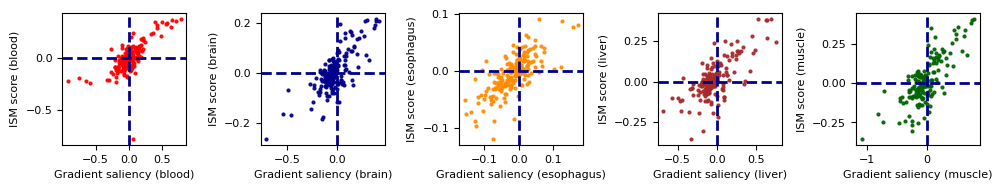

blood


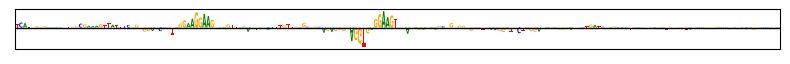

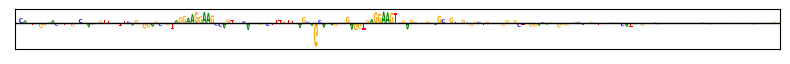

brain


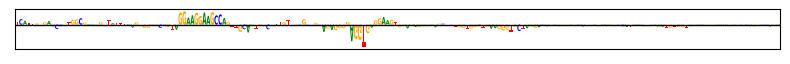

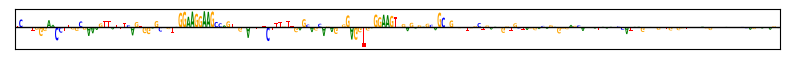

esophagus


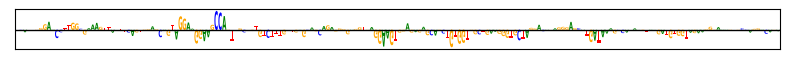

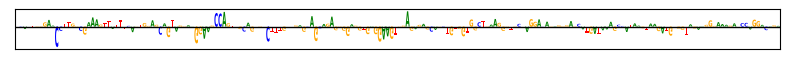

liver


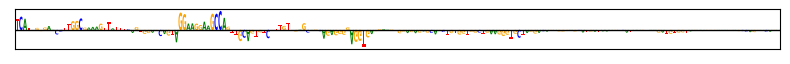

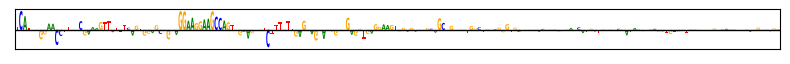

muscle


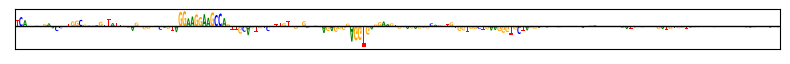

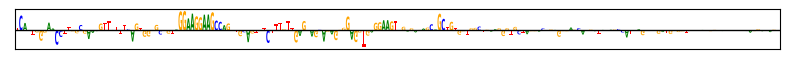

--------------------

-- Example = 8 --
 - ENSG00000204936(+)
 - chr19:43097819-43622107
blood (r = 0.69)
brain (r = 0.835)
esophagus (r = 0.797)
liver (r = 0.708)
muscle (r = 0.768)


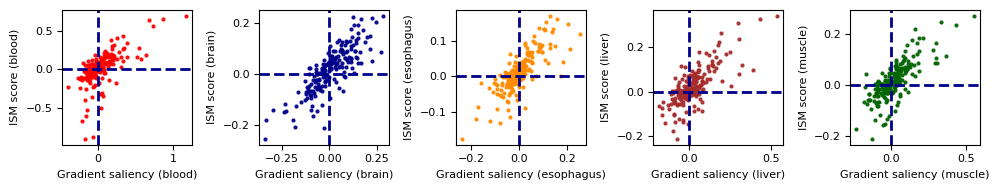

blood


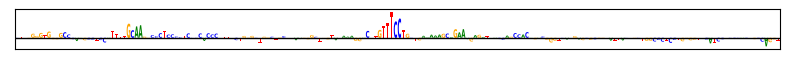

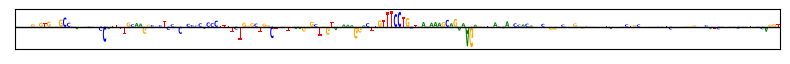

brain


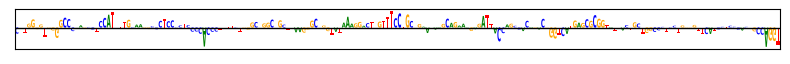

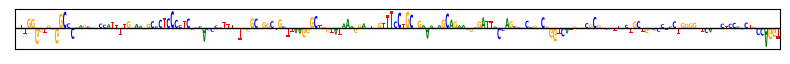

esophagus


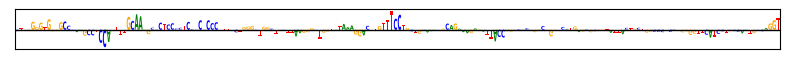

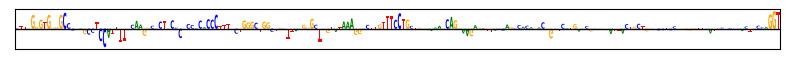

liver


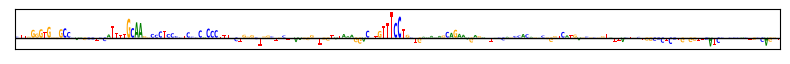

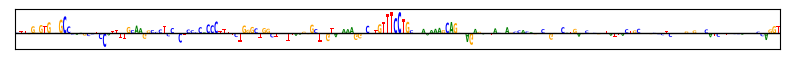

muscle


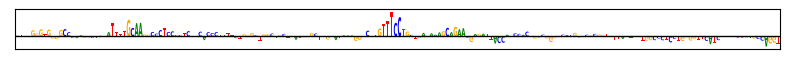

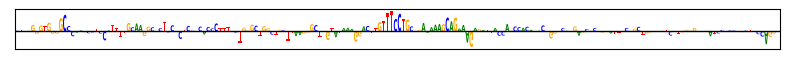

--------------------

-- Example = 9 --
 - ENSG00000112195(-)
 - chr6:40930526-41454814
blood (r = 0.648)
brain (r = 0.54)
esophagus (r = 0.612)
liver (r = 0.606)
muscle (r = 0.606)


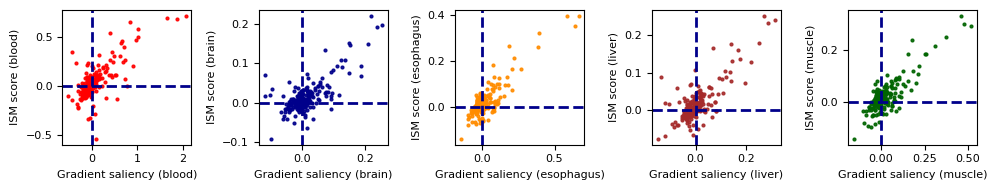

blood


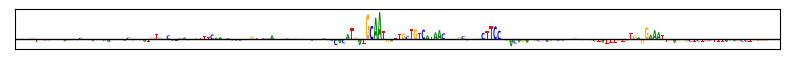

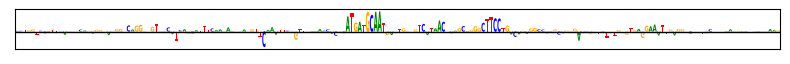

brain


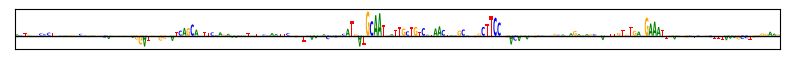

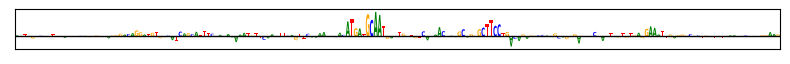

esophagus


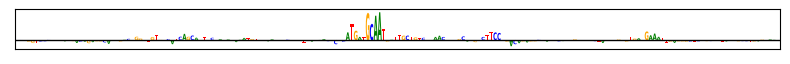

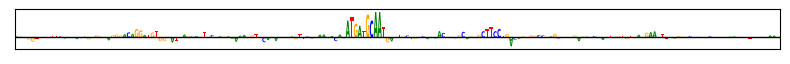

liver


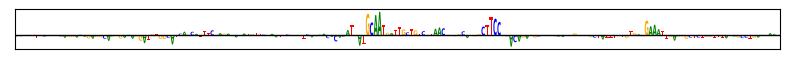

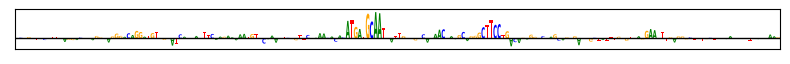

muscle


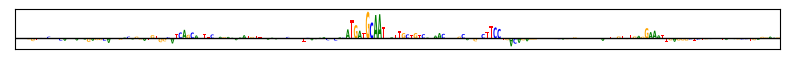

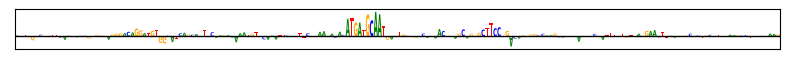

--------------------

-- Example = 10 --
 - ENSG00000255398(-)
 - chr12:122453638-122977926
blood (r = 0.736)
brain (r = 0.456)
esophagus (r = 0.693)
liver (r = 0.697)
muscle (r = 0.727)


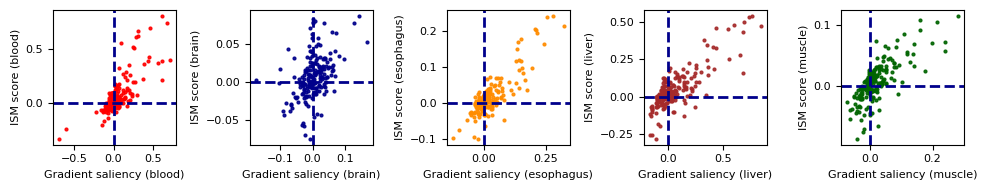

blood


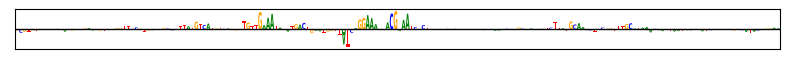

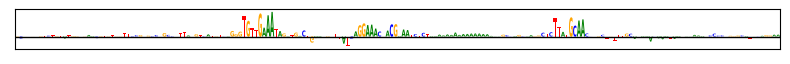

brain


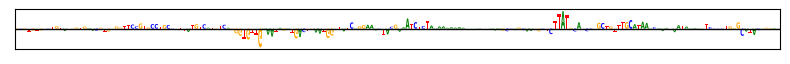

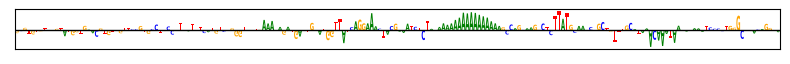

esophagus


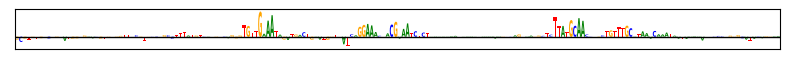

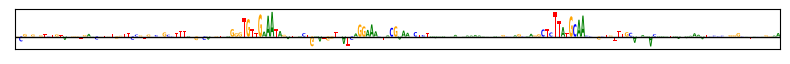

liver


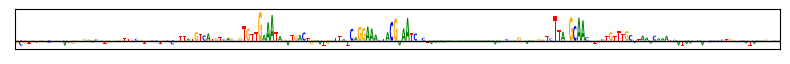

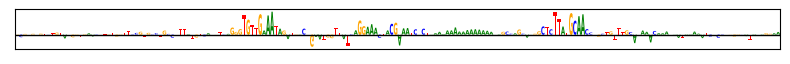

muscle


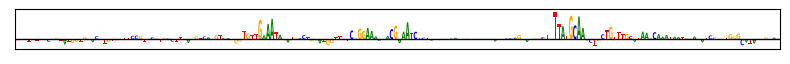

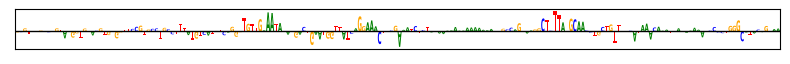

--------------------

-- Example = 11 --
 - ENSG00000158578(-)
 - chrX:54755896-55280184
blood (r = 0.766)
brain (r = 0.764)
esophagus (r = 0.782)
liver (r = 0.569)
muscle (r = 0.761)


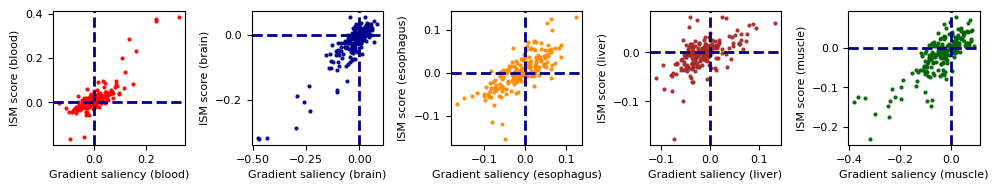

blood


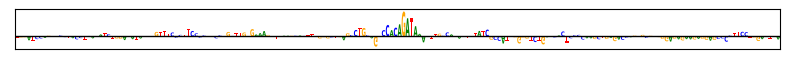

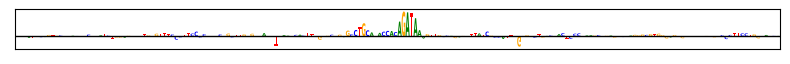

brain


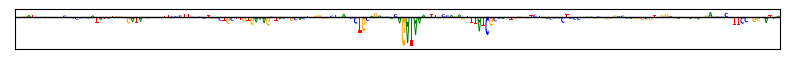

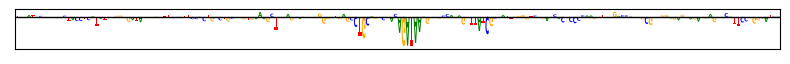

esophagus


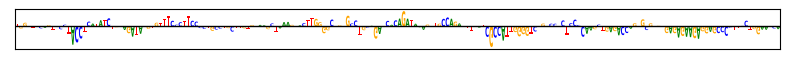

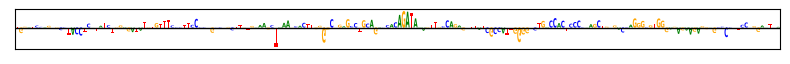

liver


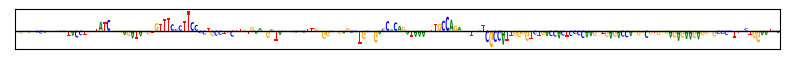

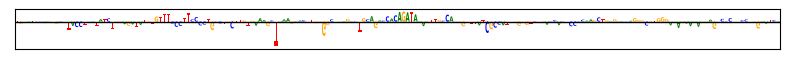

muscle


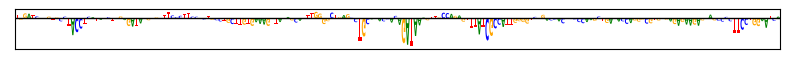

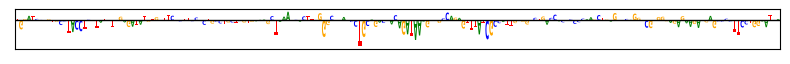

--------------------

-- Example = 12 --
 - ENSG00000124731(-)
 - chr6:41014251-41538539
blood (r = 0.711)
brain (r = 0.687)
esophagus (r = 0.651)
liver (r = 0.775)
muscle (r = 0.732)


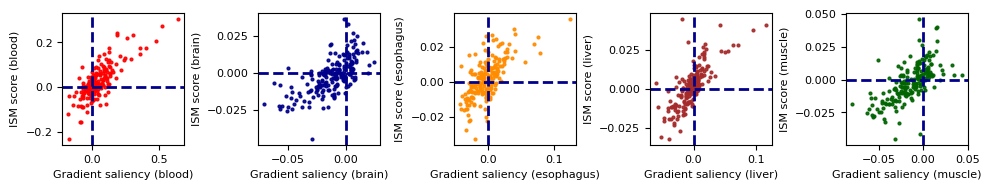

blood


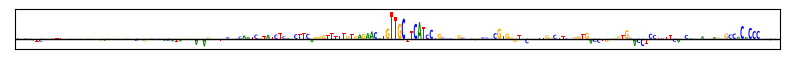

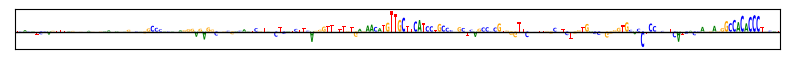

brain


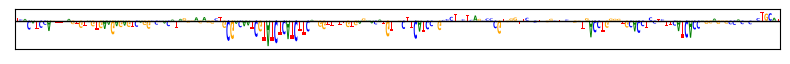

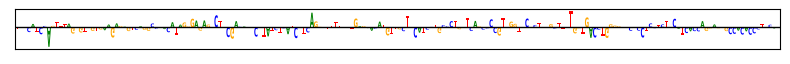

esophagus


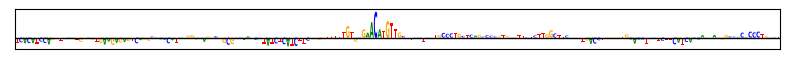

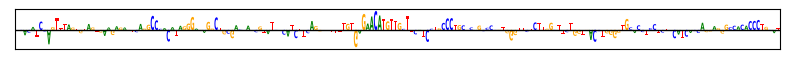

liver


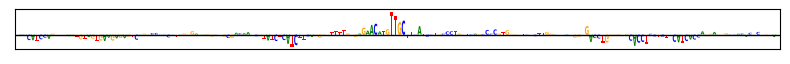

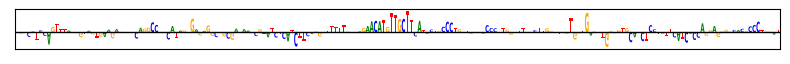

muscle


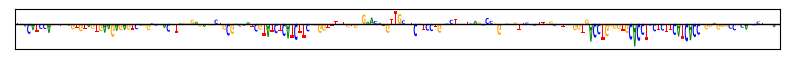

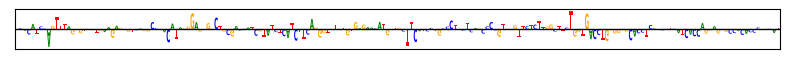

--------------------

-- Example = 13 --
 - ENSG00000164821(-)
 - chr8:6674413-7198701
blood (r = 0.697)
brain (r = 0.682)
esophagus (r = 0.663)
liver (r = 0.68)
muscle (r = 0.681)


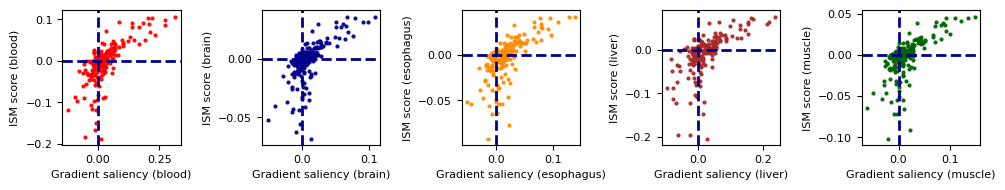

blood


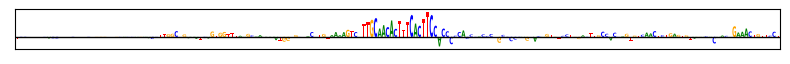

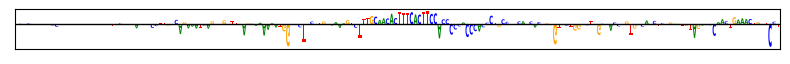

brain


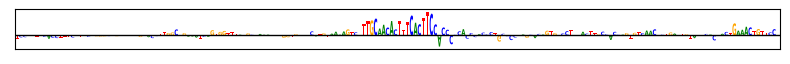

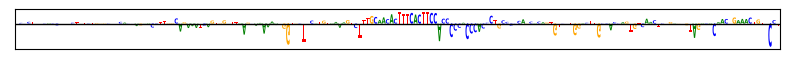

esophagus


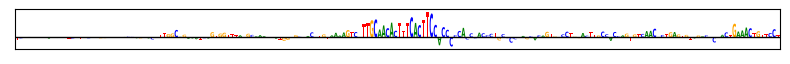

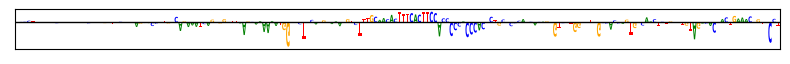

liver


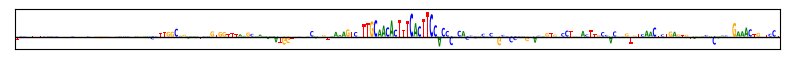

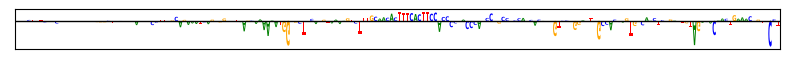

muscle


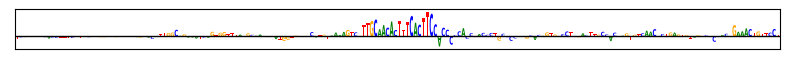

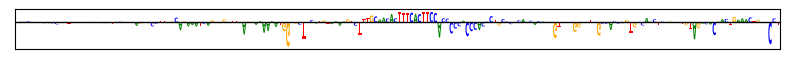

--------------------

-- Example = 14 --
 - ENSG00000183019(+)
 - chr19:7416744-7941032
blood (r = 0.646)
brain (r = 0.581)
esophagus (r = 0.484)
liver (r = 0.482)
muscle (r = 0.505)


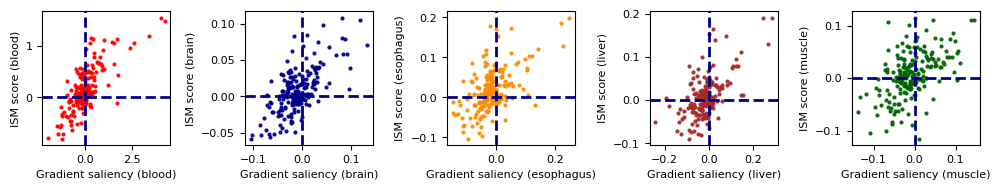

blood


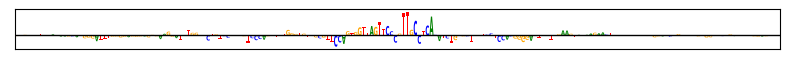

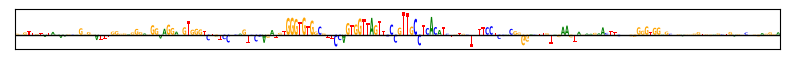

brain


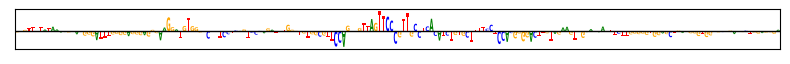

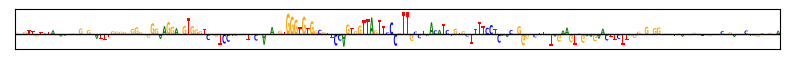

esophagus


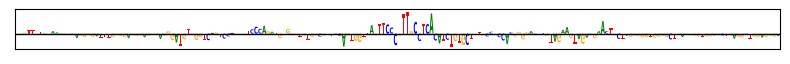

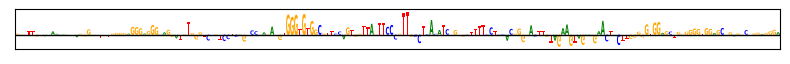

liver


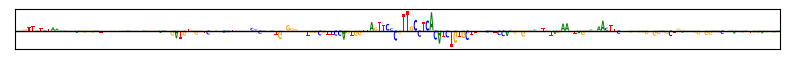

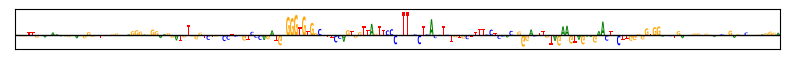

muscle


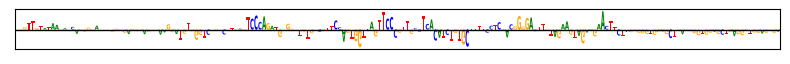

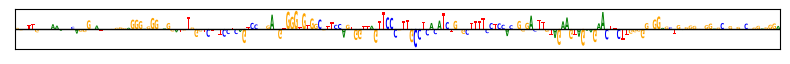

--------------------

-- Example = 15 --
 - ENSG00000105205(-)
 - chr19:39471649-39995937
blood (r = 0.774)
brain (r = 0.785)
esophagus (r = 0.742)
liver (r = 0.787)
muscle (r = 0.795)


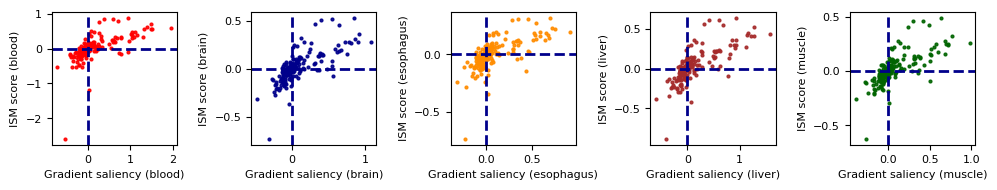

blood


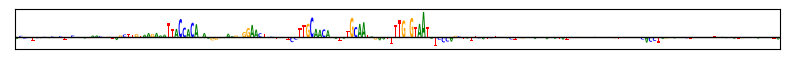

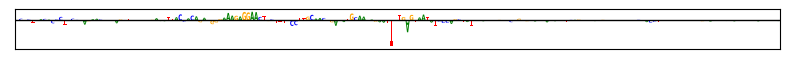

brain


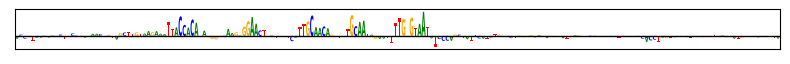

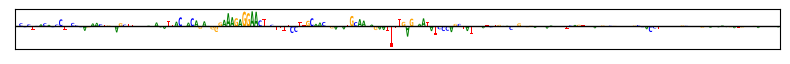

esophagus


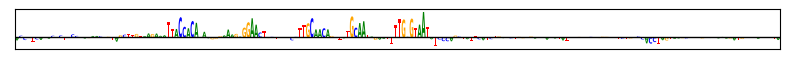

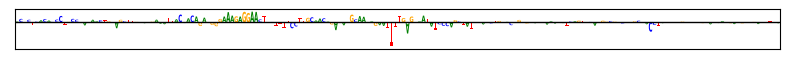

liver


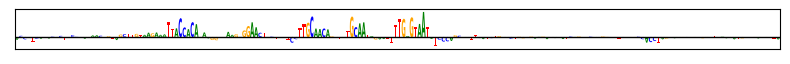

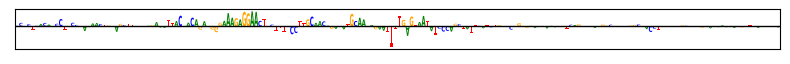

muscle


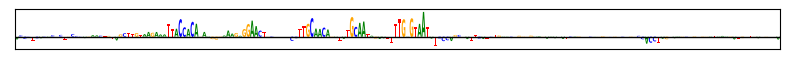

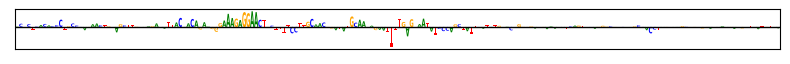

--------------------

-- Example = 16 --
 - ENSG00000170956(+)
 - chr19:41542701-42066989
blood (r = 0.75)
brain (r = 0.825)
esophagus (r = 0.734)
liver (r = 0.741)
muscle (r = 0.783)


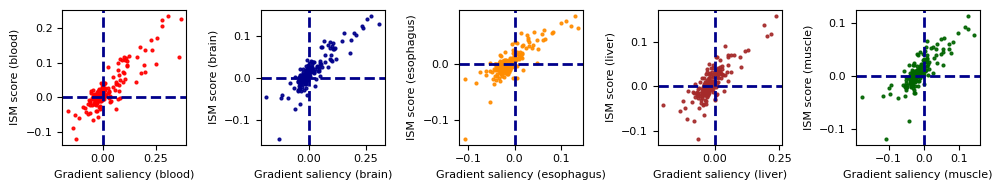

blood


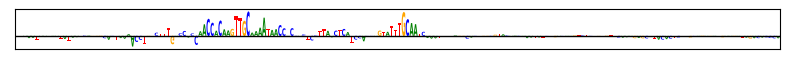

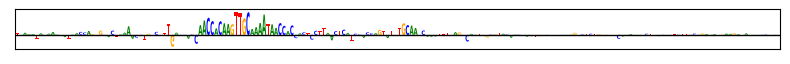

brain


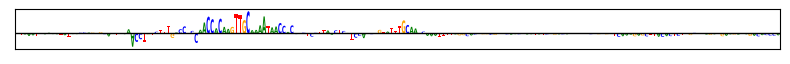

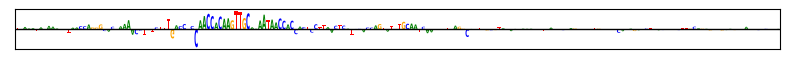

esophagus


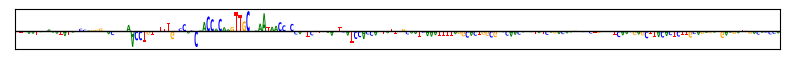

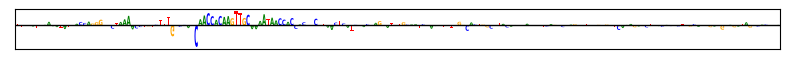

liver


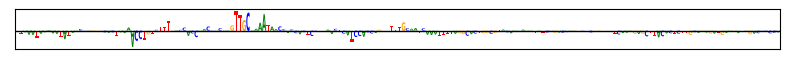

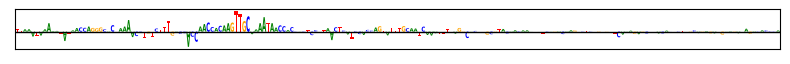

muscle


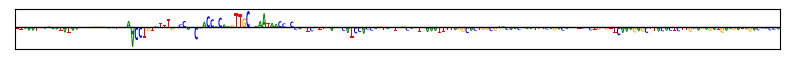

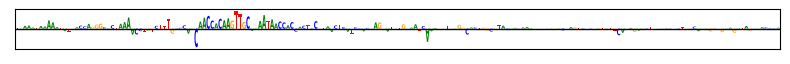

--------------------

-- Example = 17 --
 - ENSG00000163421(-)
 - chr3:71512521-72036809
blood (r = 0.724)
brain (r = 0.736)
esophagus (r = 0.805)
liver (r = 0.839)
muscle (r = 0.56)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


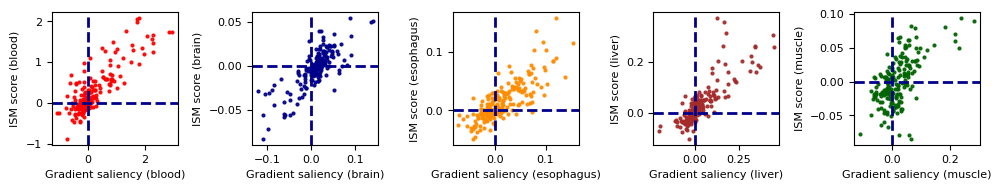

blood


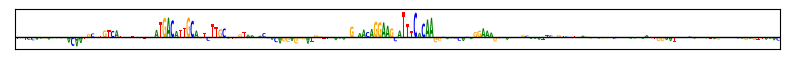

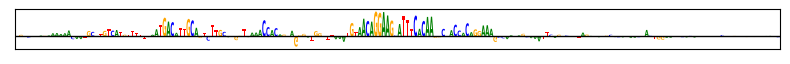

brain


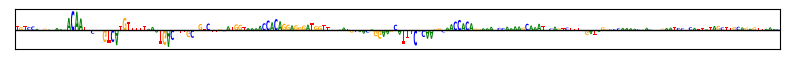

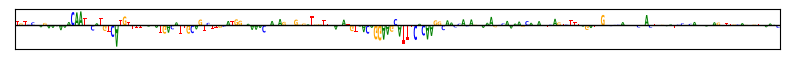

esophagus


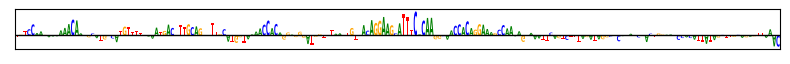

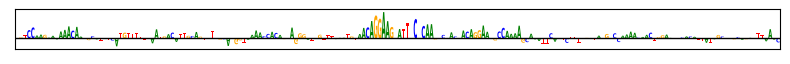

liver


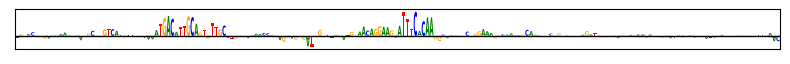

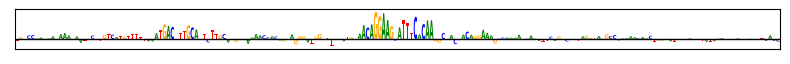

muscle


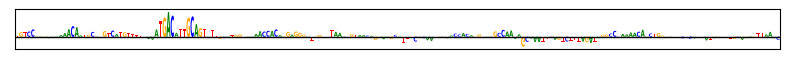

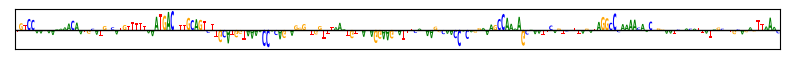

--------------------

-- Example = 18 --
 - ENSG00000131355(-)
 - chr19:14380540-14904828
blood (r = 0.767)
brain (r = 0.811)
esophagus (r = 0.806)
liver (r = 0.805)
muscle (r = 0.831)


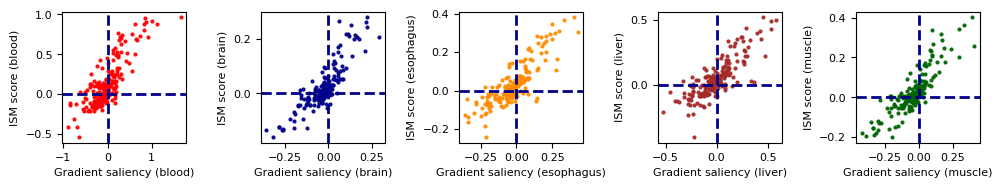

blood


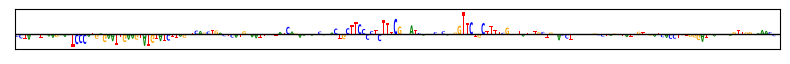

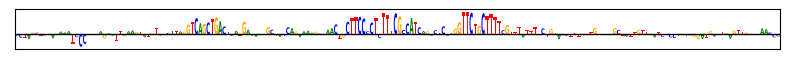

brain


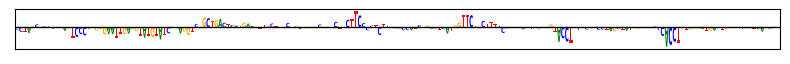

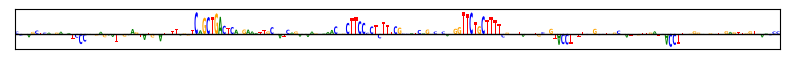

esophagus


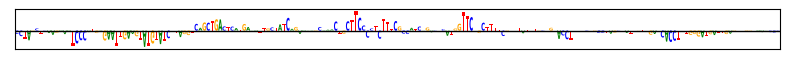

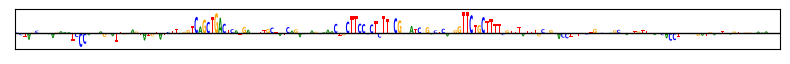

liver


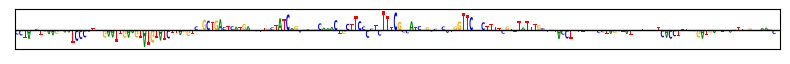

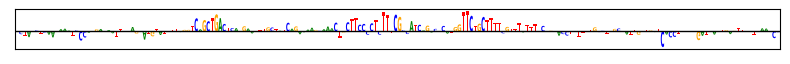

muscle


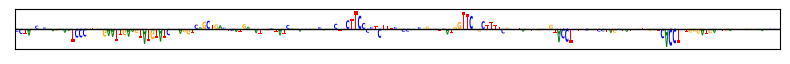

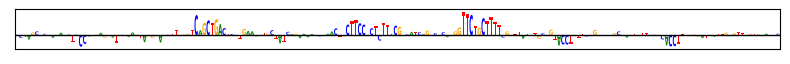

--------------------

-- Example = 19 --
 - ENSG00000128383(+)
 - chr22:38699581-39223869
blood (r = 0.816)
brain (r = 0.819)
esophagus (r = 0.79)
liver (r = 0.765)
muscle (r = 0.815)


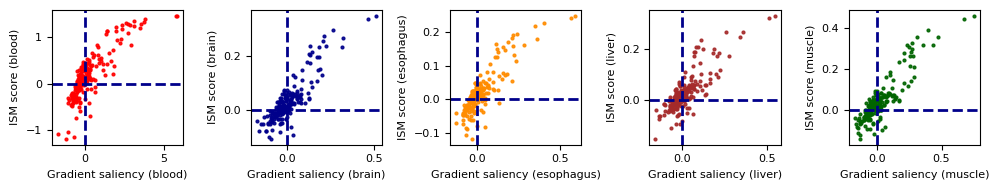

blood


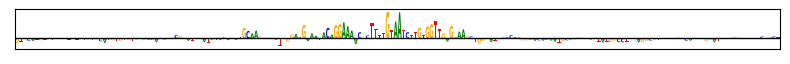

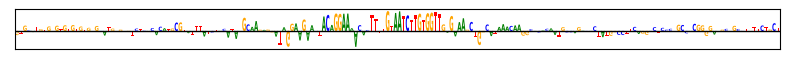

brain


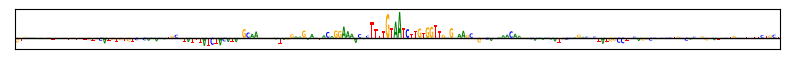

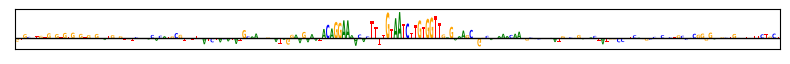

esophagus


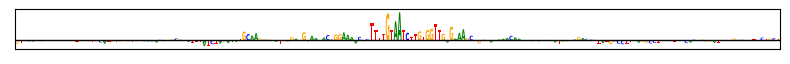

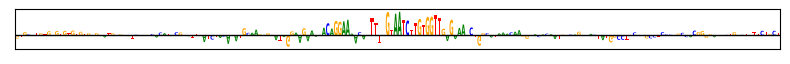

liver


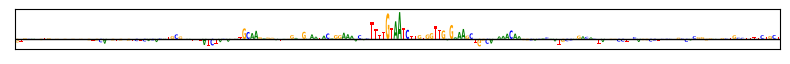

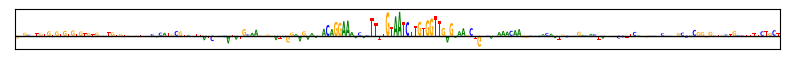

muscle


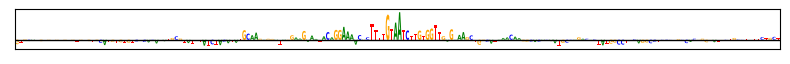

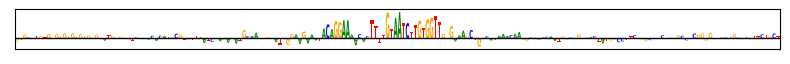

--------------------

-- Example = 20 --
 - ENSG00000186431(+)
 - chr19:54626701-55150989
blood (r = 0.721)
brain (r = 0.802)
esophagus (r = 0.791)
liver (r = 0.784)
muscle (r = 0.789)


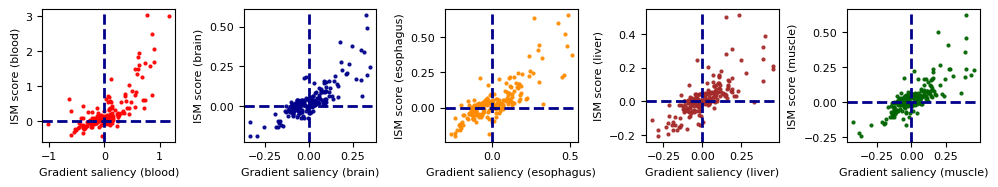

blood


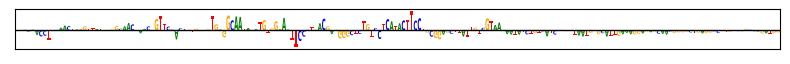

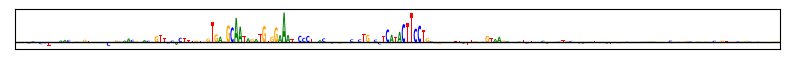

brain


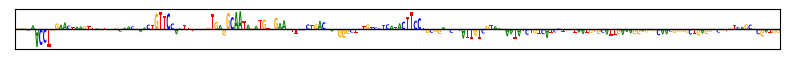

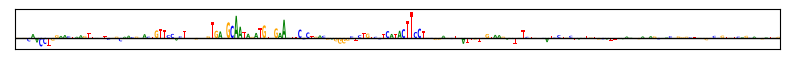

esophagus


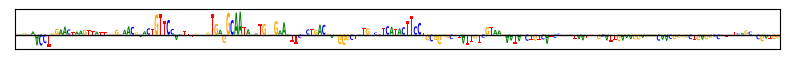

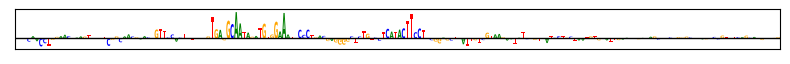

liver


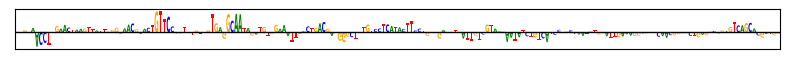

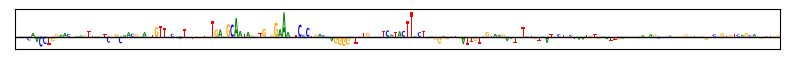

muscle


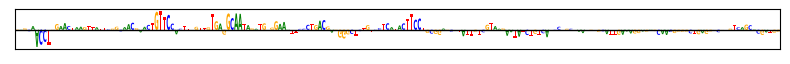

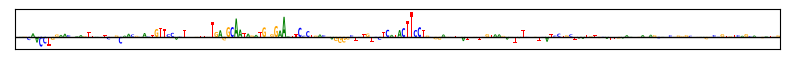

--------------------

-- Example = 21 --
 - ENSG00000008438(-)
 - chr19:45758818-46283106
blood (r = 0.806)
brain (r = 0.727)
esophagus (r = 0.752)
liver (r = 0.784)
muscle (r = 0.762)


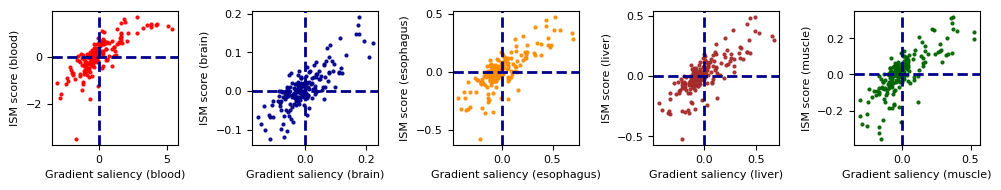

blood


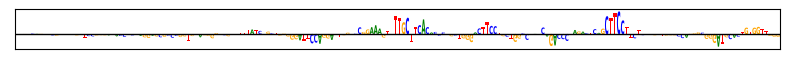

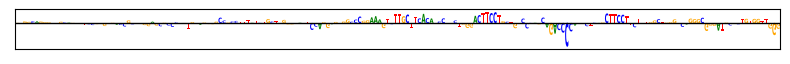

brain


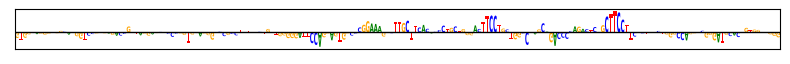

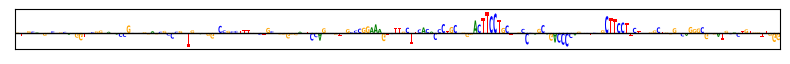

esophagus


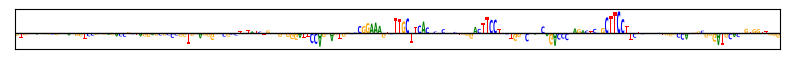

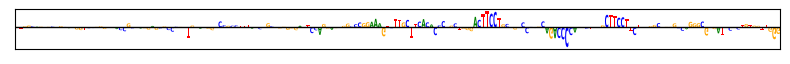

liver


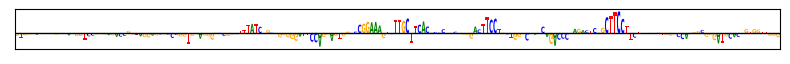

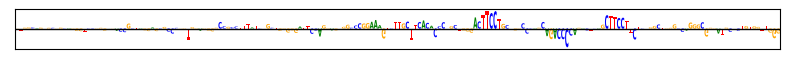

muscle


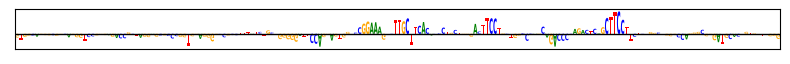

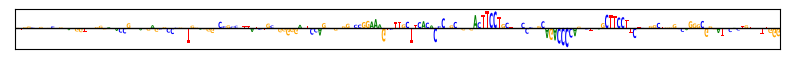

--------------------

-- Example = 22 --
 - ENSG00000166947(-)
 - chr15:42946773-43471061
blood (r = 0.68)
brain (r = 0.534)
esophagus (r = 0.565)
liver (r = 0.686)
muscle (r = 0.508)


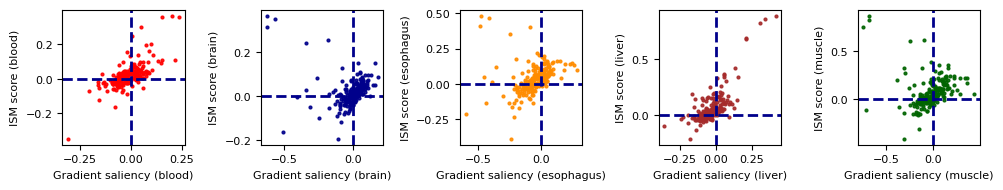

blood


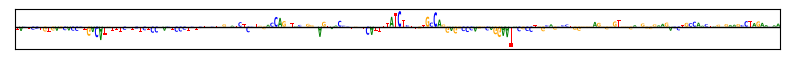

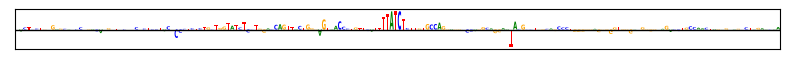

brain


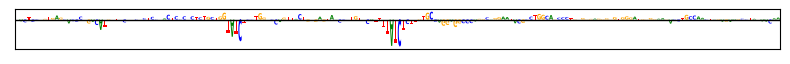

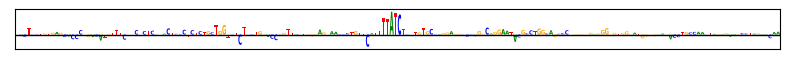

esophagus


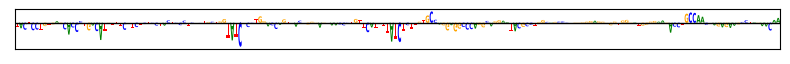

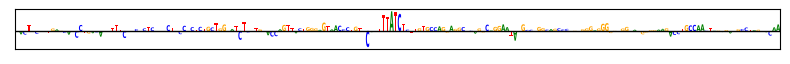

liver


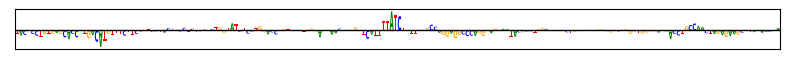

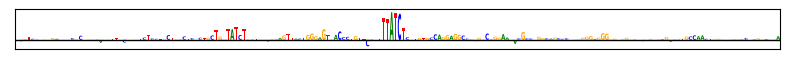

muscle


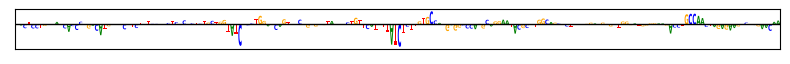

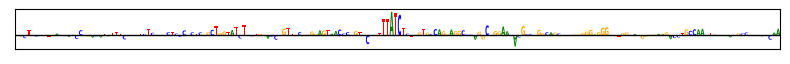

--------------------

-- Example = 23 --
 - ENSG00000163464(-)
 - chr2:217901962-218426250
blood (r = 0.588)
brain (r = 0.607)
esophagus (r = 0.513)
liver (r = 0.6)
muscle (r = 0.561)


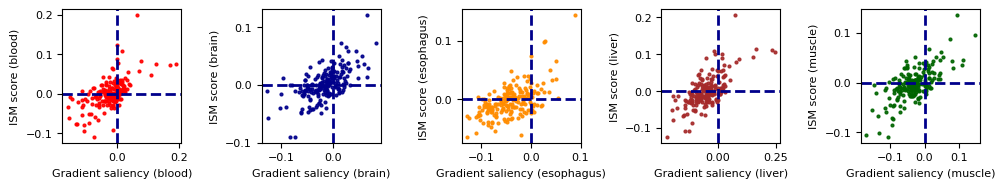

blood


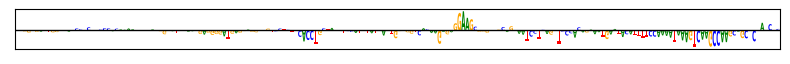

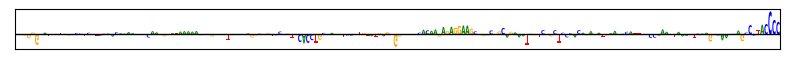

brain


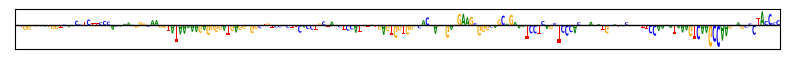

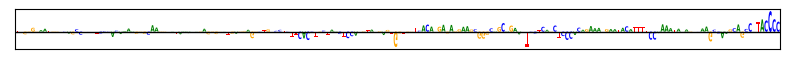

esophagus


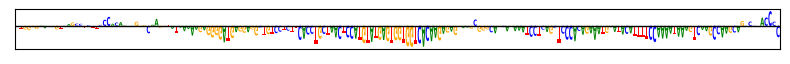

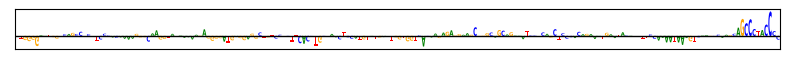

liver


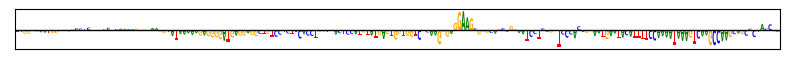

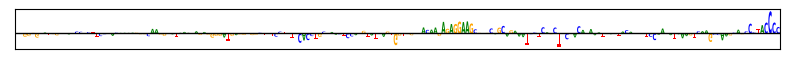

muscle


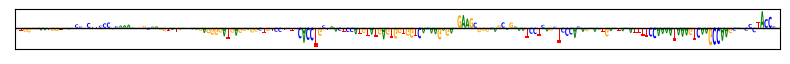

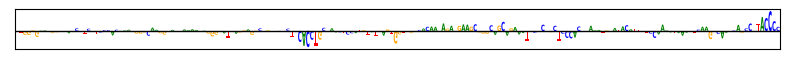

--------------------

-- Example = 24 --
 - ENSG00000173535(+)
 - chr8:22851573-23375861
blood (r = 0.688)
brain (r = 0.729)
esophagus (r = 0.585)
liver (r = 0.712)
muscle (r = 0.73)


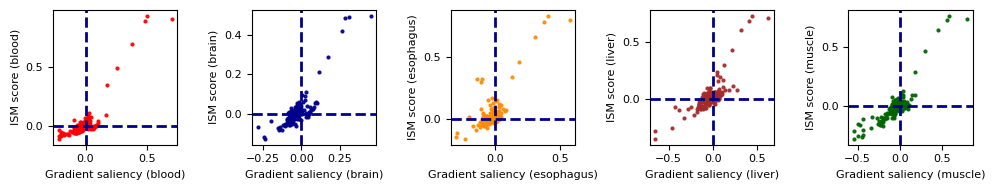

blood


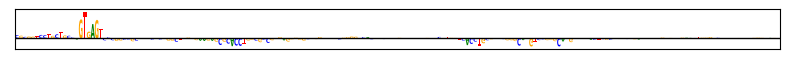

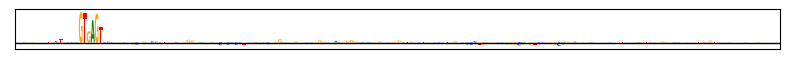

brain


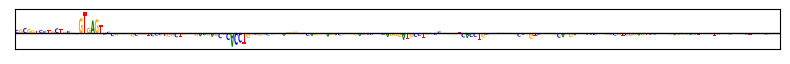

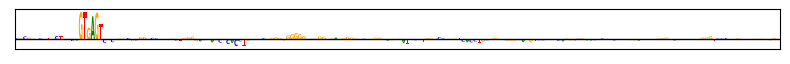

esophagus


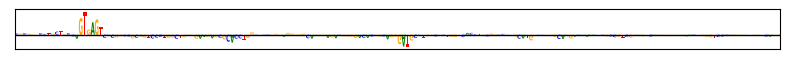

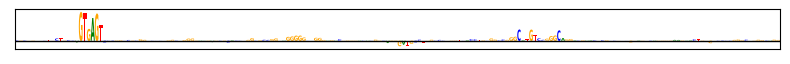

liver


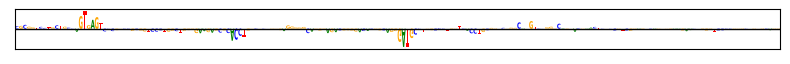

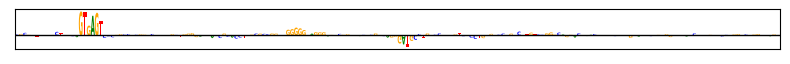

muscle


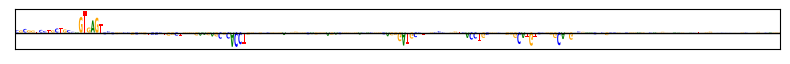

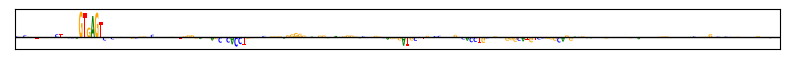

--------------------

-- Example = 25 --
 - ENSG00000104918(+)
 - chr19:7407705-7931993
blood (r = 0.667)
brain (r = 0.691)
esophagus (r = 0.68)
liver (r = 0.631)
muscle (r = 0.668)


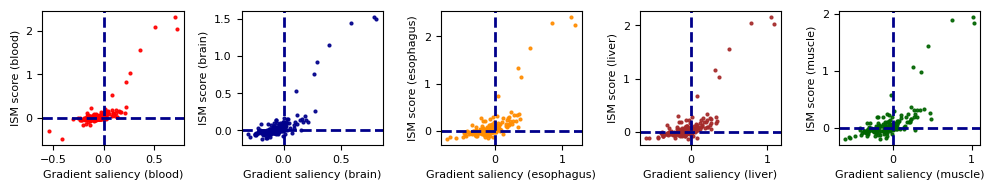

blood


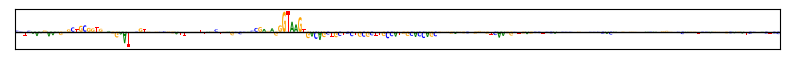

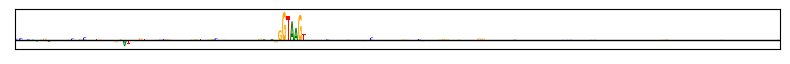

brain


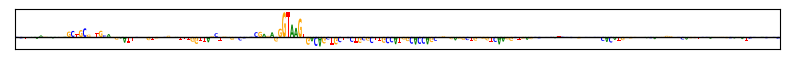

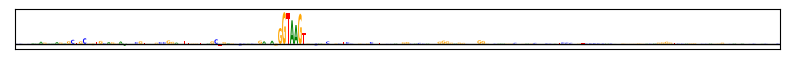

esophagus


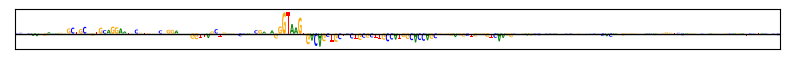

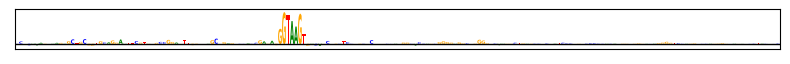

liver


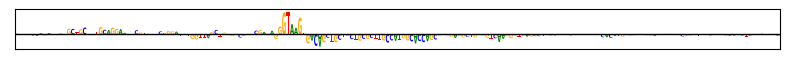

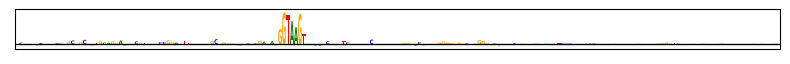

muscle


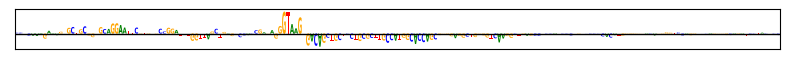

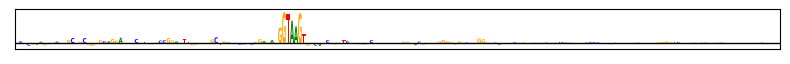

--------------------

-- Example = 26 --
 - ENSG00000213934(-)
 - chr11:4986998-5511286
blood (r = 0.574)
brain (r = 0.565)
esophagus (r = 0.613)
liver (r = 0.621)
muscle (r = 0.458)


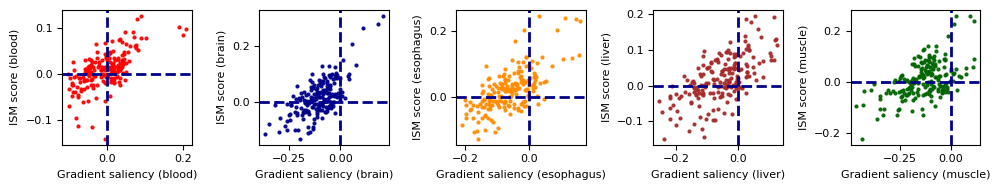

blood


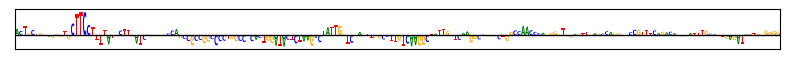

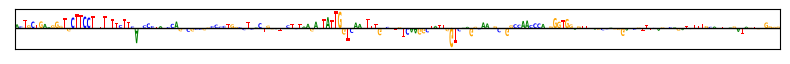

brain


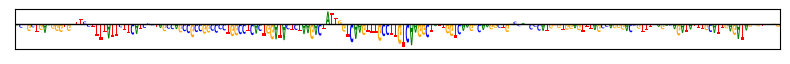

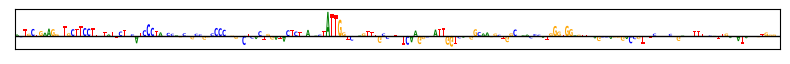

esophagus


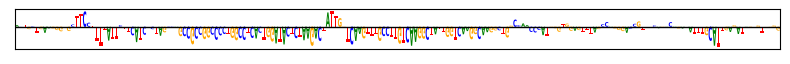

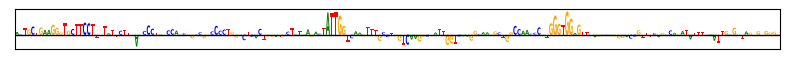

liver


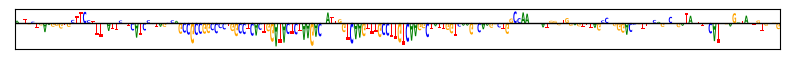

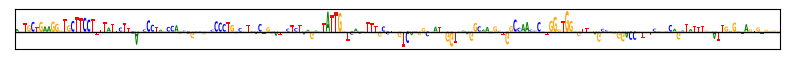

muscle


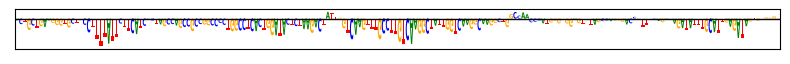

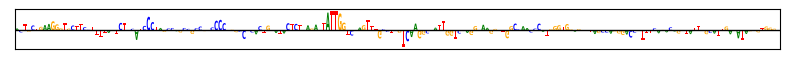

--------------------

-- Example = 27 --
 - ENSG00000196565(-)
 - chr11:4991922-5516210
blood (r = 0.708)
brain (r = 0.666)
esophagus (r = 0.624)
liver (r = 0.666)
muscle (r = 0.575)


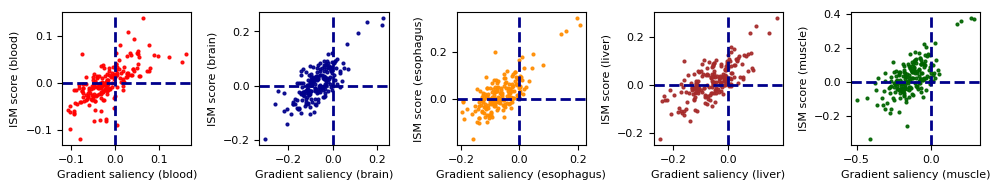

blood


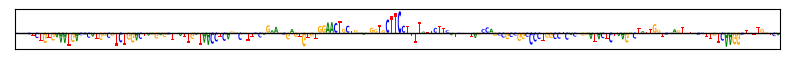

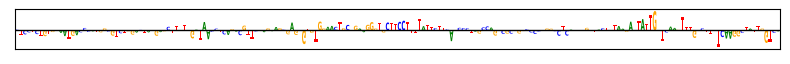

brain


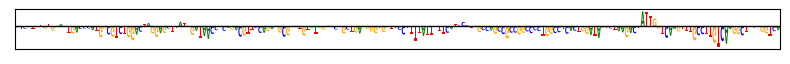

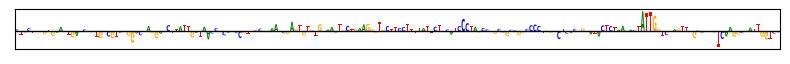

esophagus


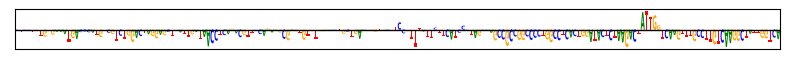

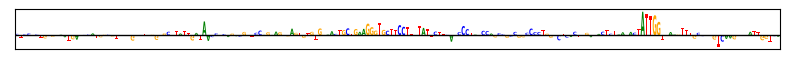

liver


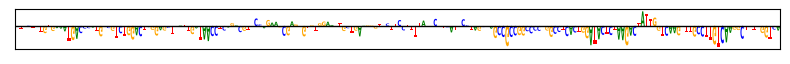

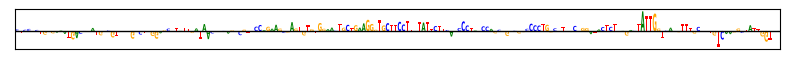

muscle


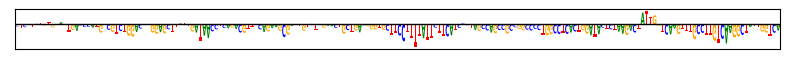

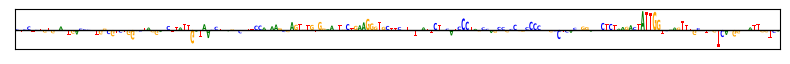

--------------------

-- Example = 28 --
 - ENSG00000169397(+)
 - chr14:20629815-21154103
blood (r = 0.771)
brain (r = 0.807)
esophagus (r = 0.785)
liver (r = 0.791)
muscle (r = 0.785)


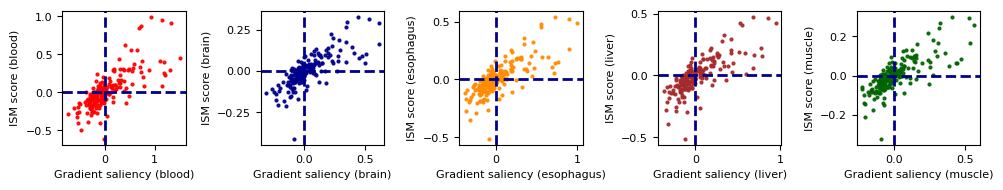

blood


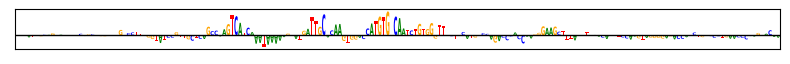

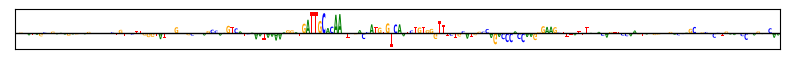

brain


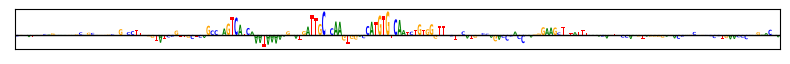

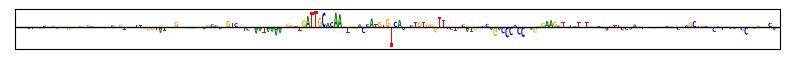

esophagus


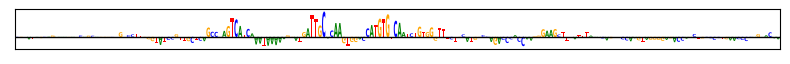

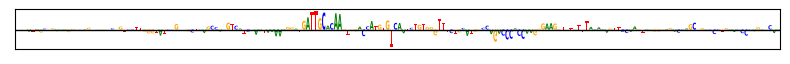

liver


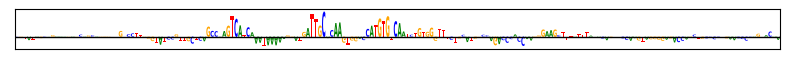

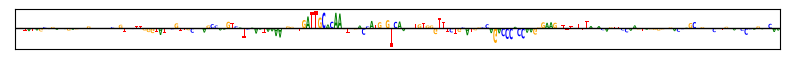

muscle


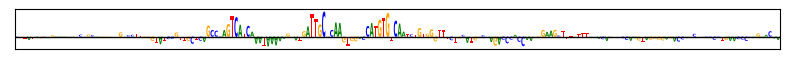

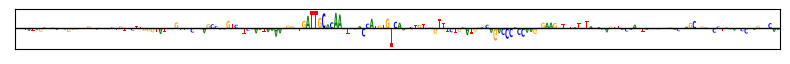

--------------------

-- Example = 29 --
 - ENSG00000182782(-)
 - chr12:122440180-122964468
blood (r = 0.69)
brain (r = 0.827)
esophagus (r = 0.69)
liver (r = 0.686)
muscle (r = 0.721)


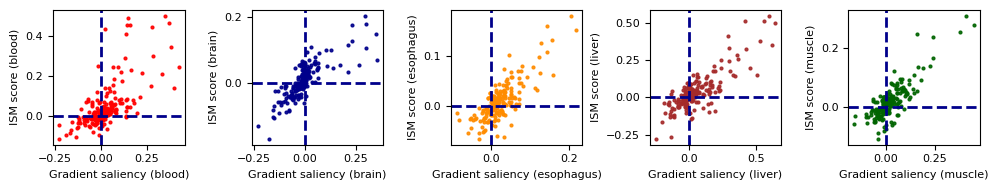

blood


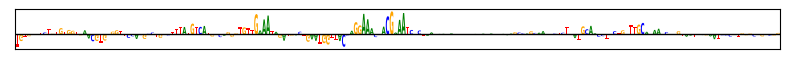

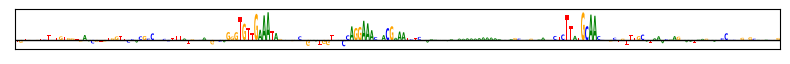

brain


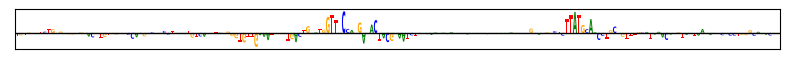

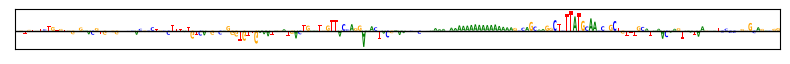

esophagus


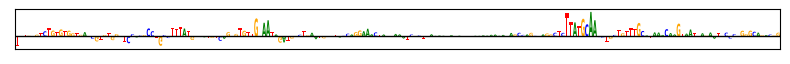

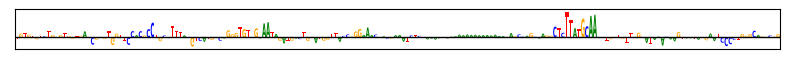

liver


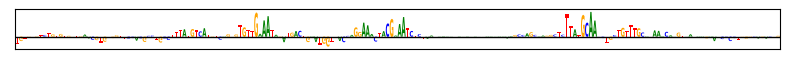

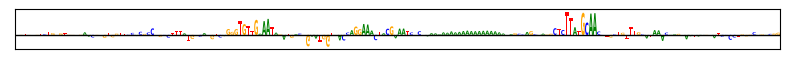

muscle


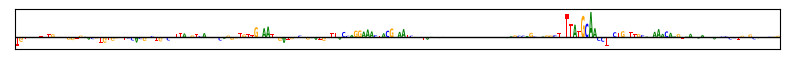

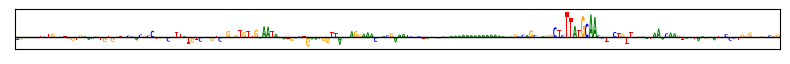

--------------------

-- Example = 30 --
 - ENSG00000163737(-)
 - chr4:73719167-74243455
blood (r = 0.56)
brain (r = 0.503)
esophagus (r = 0.543)
liver (r = 0.443)
muscle (r = 0.494)


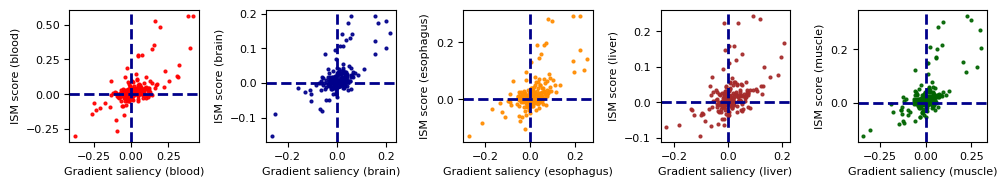

blood


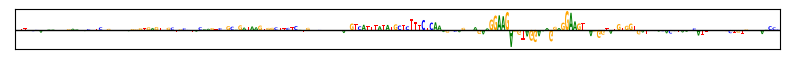

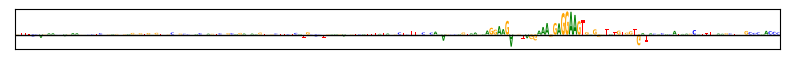

brain


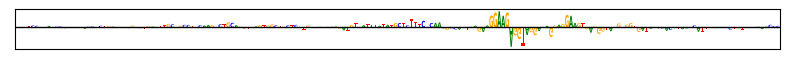

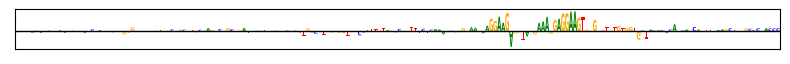

esophagus


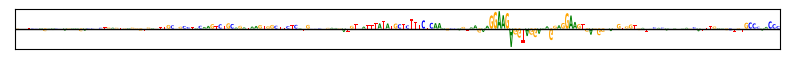

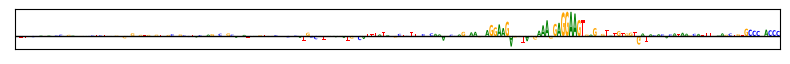

liver


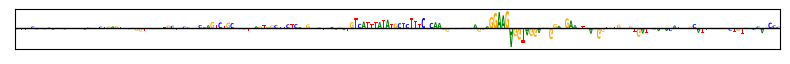

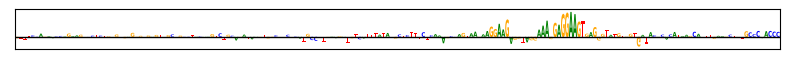

muscle


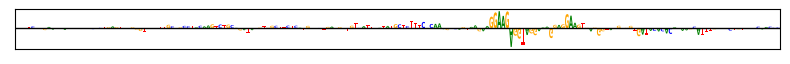

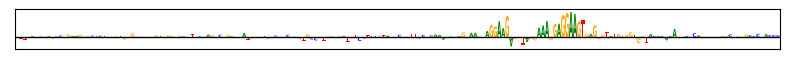

--------------------

-- Example = 31 --
 - ENSG00000159339(+)
 - chr1:17085559-17609847
blood (r = 0.824)
brain (r = 0.725)
esophagus (r = 0.688)
liver (r = 0.784)
muscle (r = 0.73)


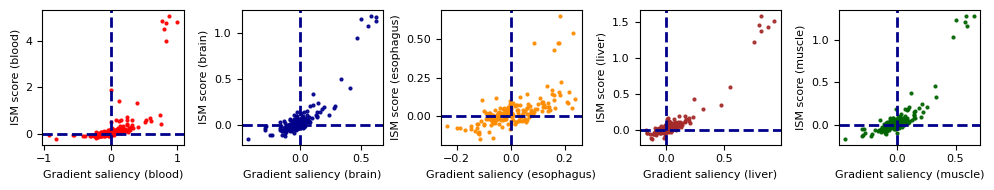

blood


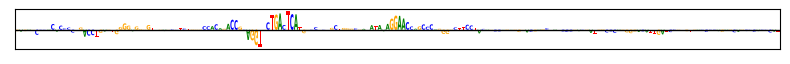

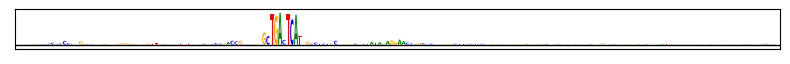

brain


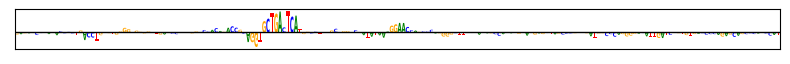

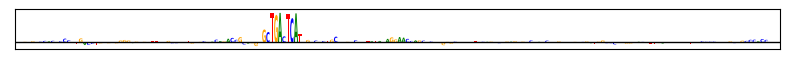

esophagus


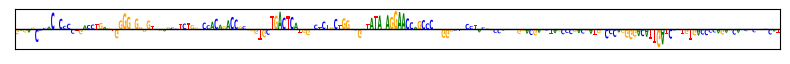

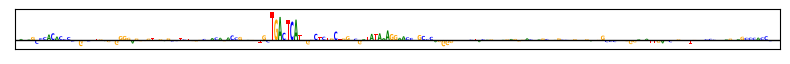

liver


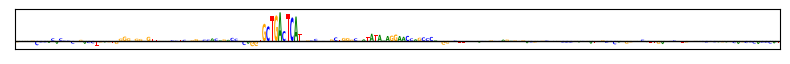

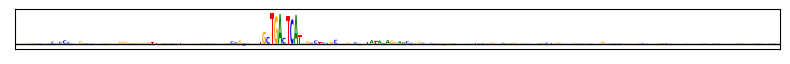

muscle


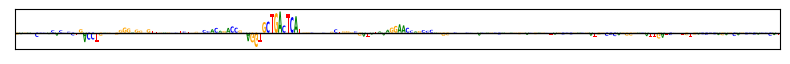

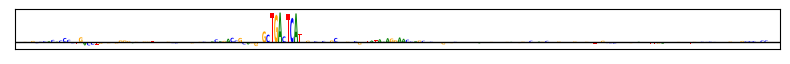

--------------------

-- Example = 32 --
 - ENSG00000204010(+)
 - chr10:89121851-89646139
blood (r = 0.751)
brain (r = 0.693)
esophagus (r = 0.756)
liver (r = 0.67)
muscle (r = 0.516)


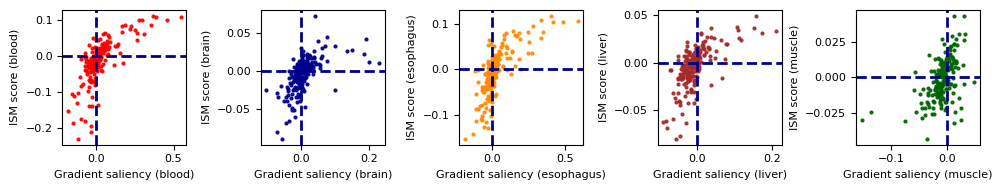

blood


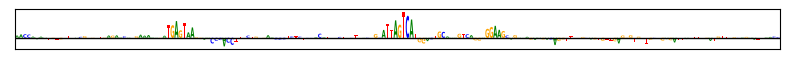

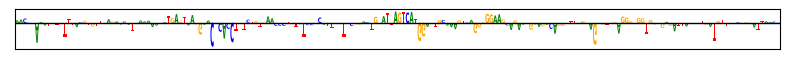

brain


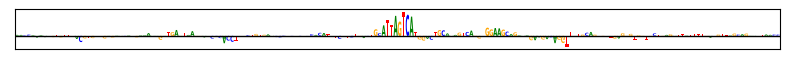

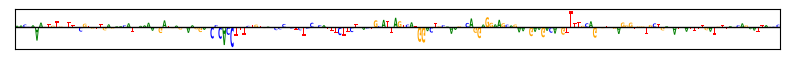

esophagus


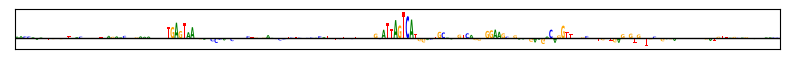

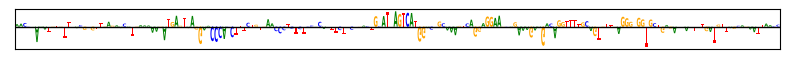

liver


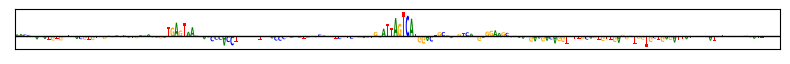

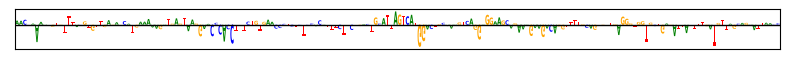

muscle


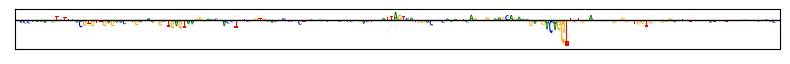

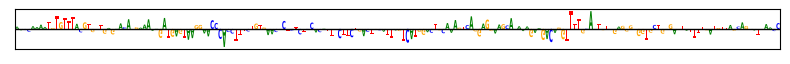

--------------------

-- Example = 33 --
 - ENSG00000134827(-)
 - chr11:59596271-60120559
blood (r = 0.778)
brain (r = 0.791)
esophagus (r = 0.774)
liver (r = 0.788)
muscle (r = 0.736)


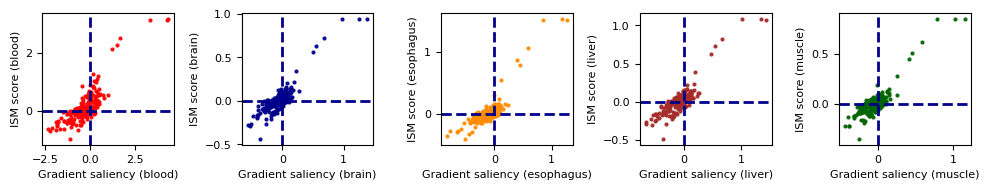

blood


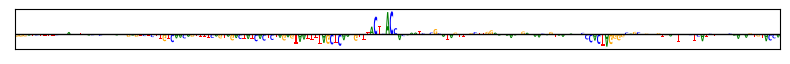

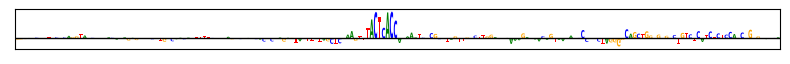

brain


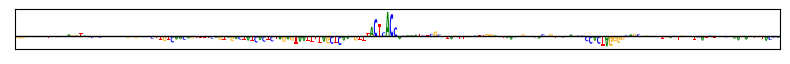

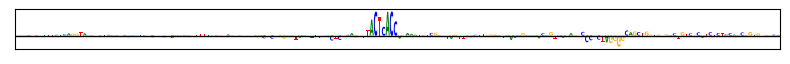

esophagus


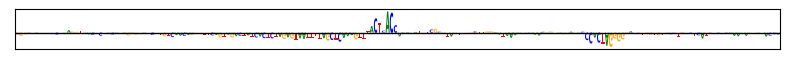

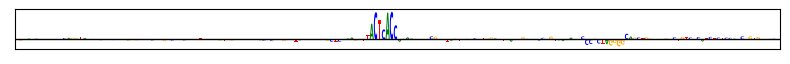

liver


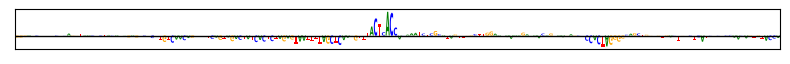

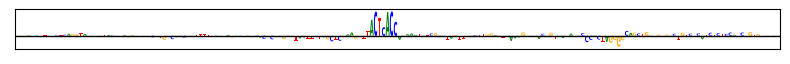

muscle


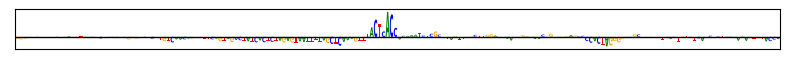

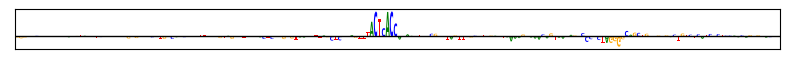

--------------------

-- Example = 34 --
 - ENSG00000123405(-)
 - chr12:54031914-54556202
blood (r = 0.805)
brain (r = 0.77)
esophagus (r = 0.827)
liver (r = 0.754)
muscle (r = 0.733)


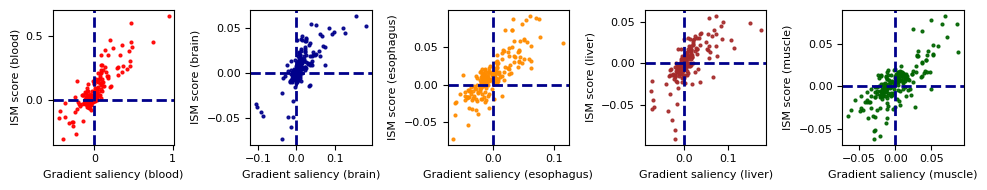

blood


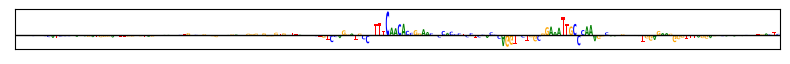

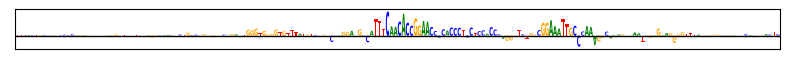

brain


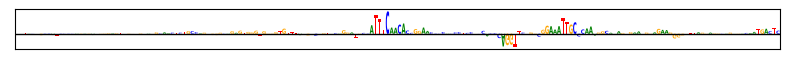

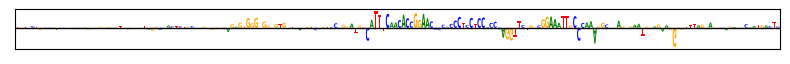

esophagus


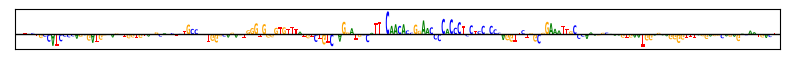

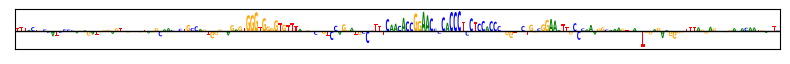

liver


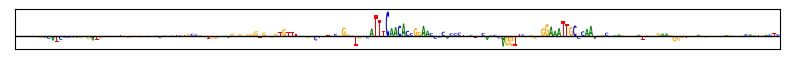

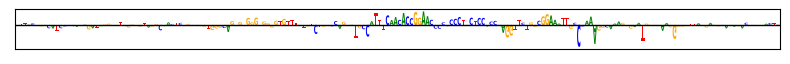

muscle


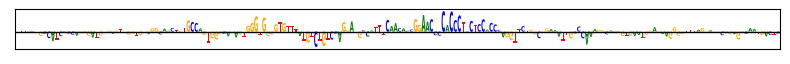

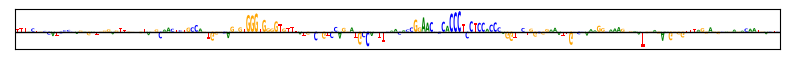

--------------------

-- Example = 35 --
 - ENSG00000124469(-)
 - chr19:42323768-42848056
blood (r = 0.798)
brain (r = 0.748)
esophagus (r = 0.778)
liver (r = 0.781)
muscle (r = 0.794)


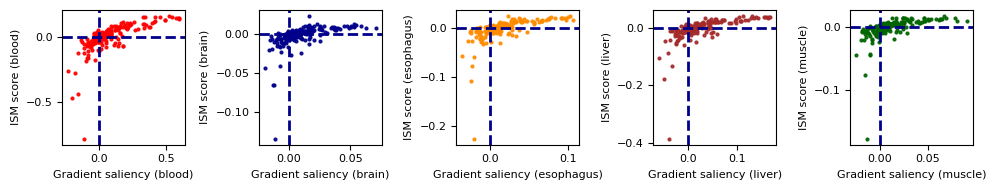

blood


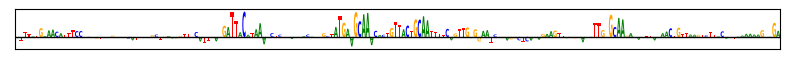

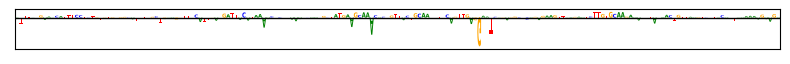

brain


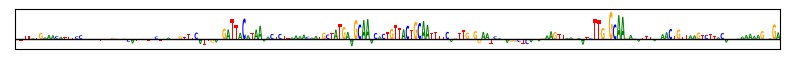

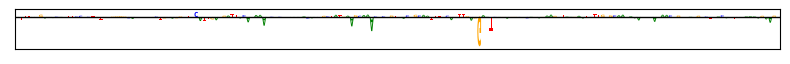

esophagus


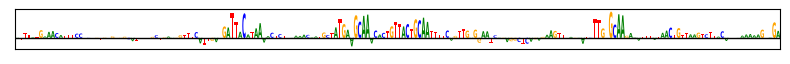

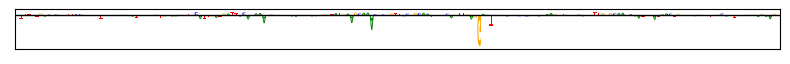

liver


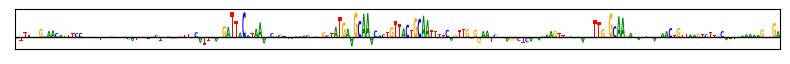

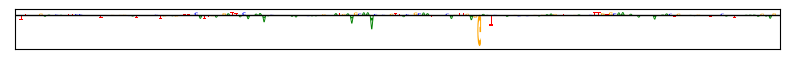

muscle


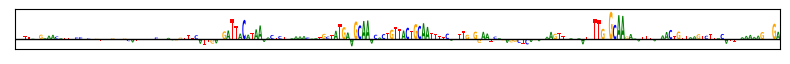

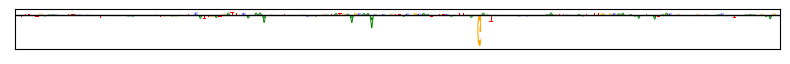

--------------------

-- Example = 36 --
 - ENSG00000189068(-)
 - chr19:53788928-54313216
blood (r = 0.759)
brain (r = 0.729)
esophagus (r = 0.776)
liver (r = 0.772)
muscle (r = 0.754)


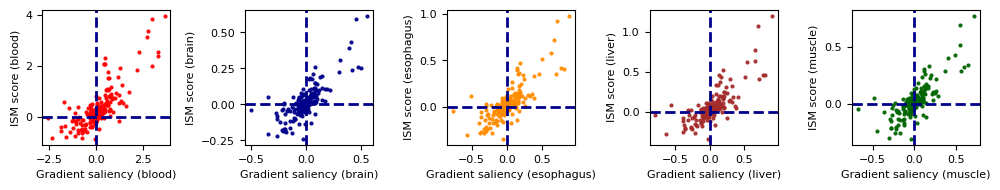

blood


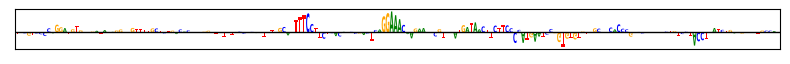

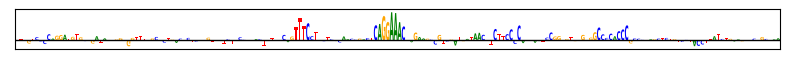

brain


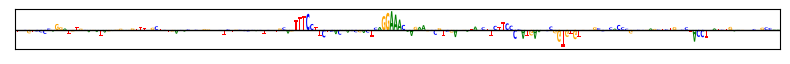

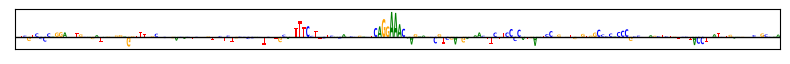

esophagus


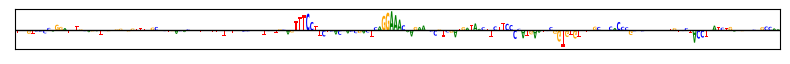

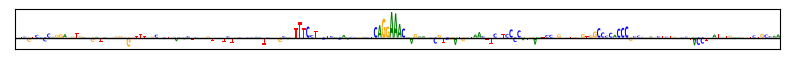

liver


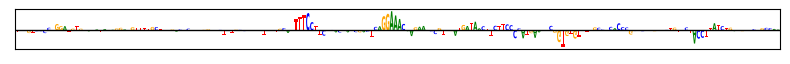

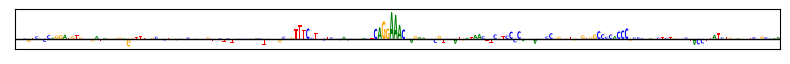

muscle


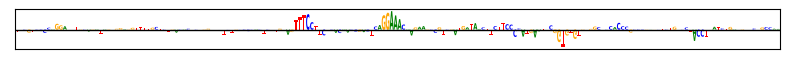

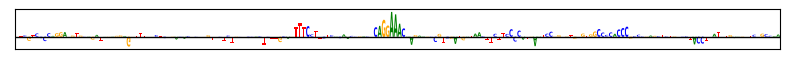

--------------------

-- Example = 37 --
 - ENSG00000257335(+)
 - chr7:141802295-142326583
blood (r = 0.847)
brain (r = 0.81)
esophagus (r = 0.864)
liver (r = 0.608)
muscle (r = 0.843)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


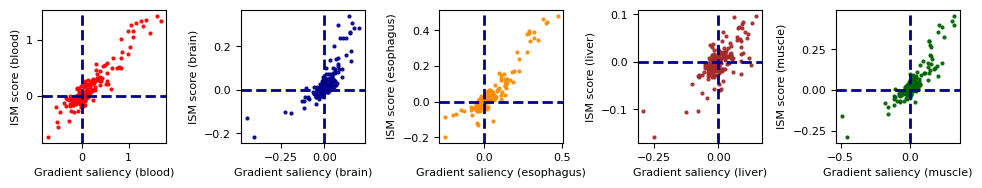

blood


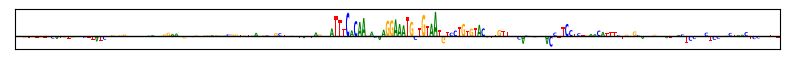

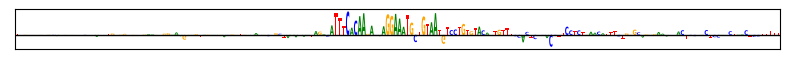

brain


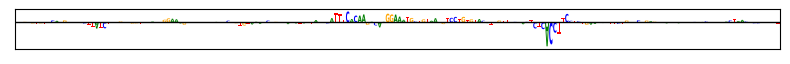

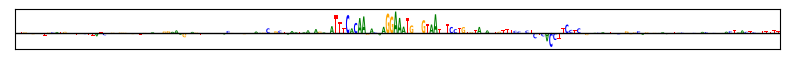

esophagus


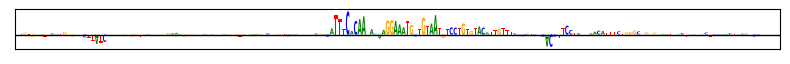

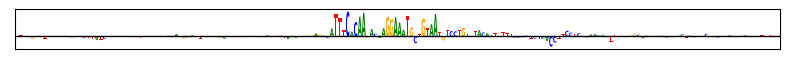

liver


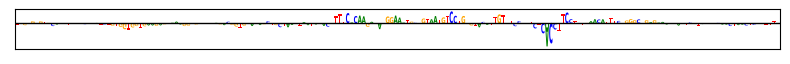

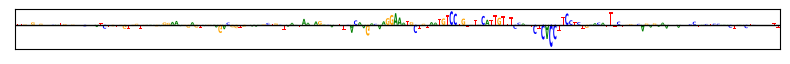

muscle


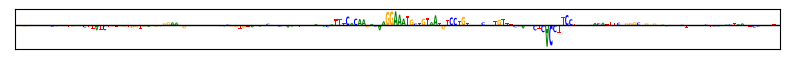

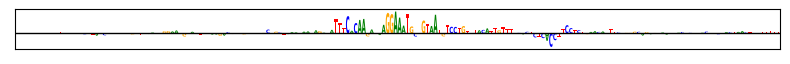

--------------------

-- Example = 38 --
 - ENSG00000164047(+)
 - chr3:47962314-48486602
blood (r = 0.604)
brain (r = 0.695)
esophagus (r = 0.802)
liver (r = 0.773)
muscle (r = 0.752)


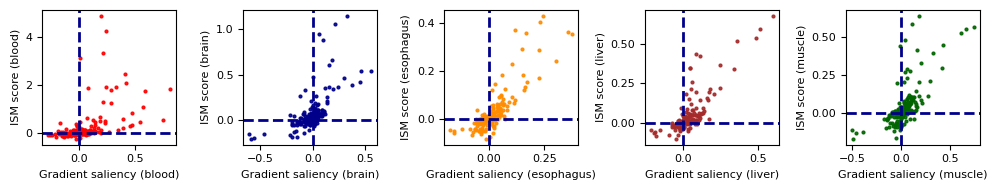

blood


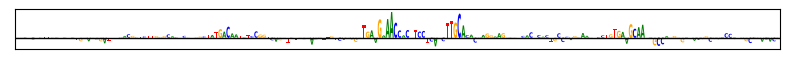

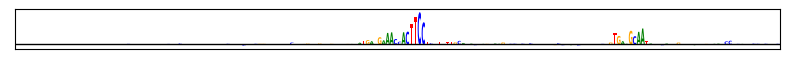

brain


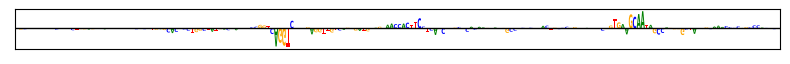

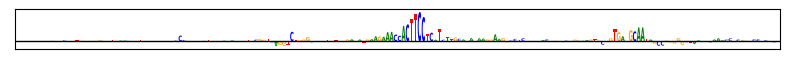

esophagus


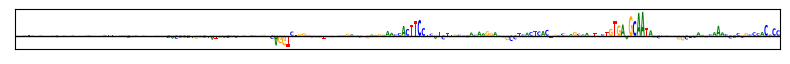

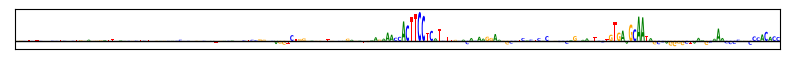

liver


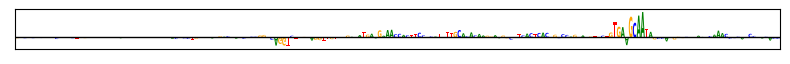

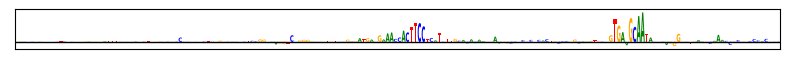

muscle


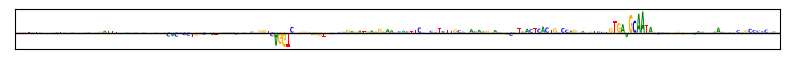

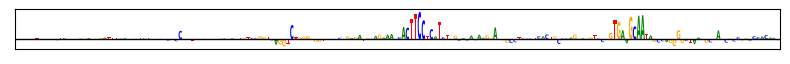

--------------------

-- Example = 39 --
 - ENSG00000085265(-)
 - chr9:134645268-135169556
blood (r = 0.724)
brain (r = 0.691)
esophagus (r = 0.694)
liver (r = 0.679)
muscle (r = 0.686)


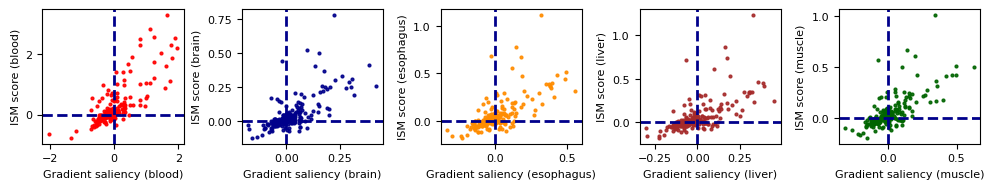

blood


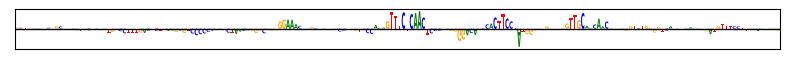

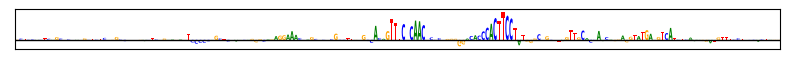

brain


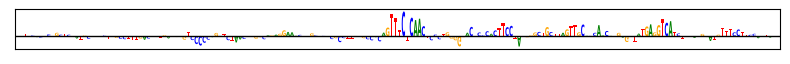

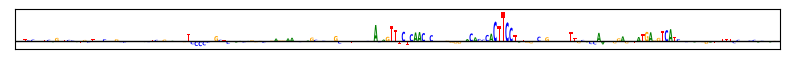

esophagus


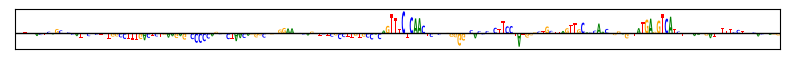

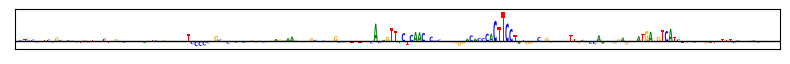

liver


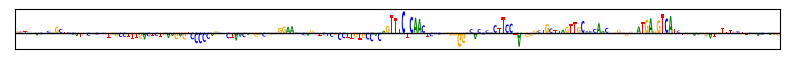

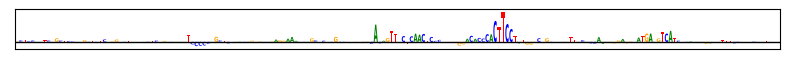

muscle


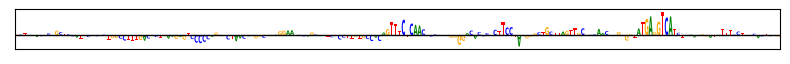

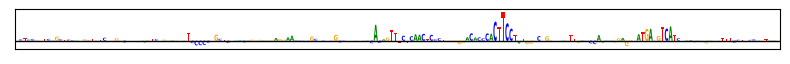

--------------------

-- Example = 40 --
 - ENSG00000133742(-)
 - chr8:85070557-85594845
blood (r = 0.764)
brain (r = 0.775)
esophagus (r = 0.746)
liver (r = 0.603)
muscle (r = 0.727)


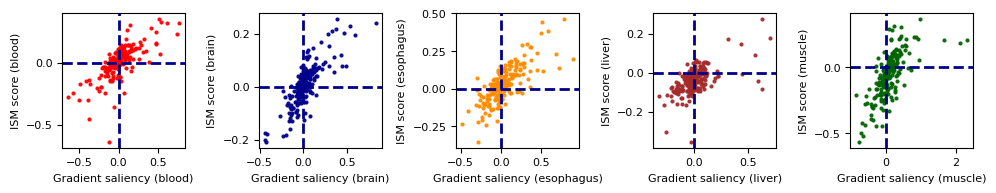

blood


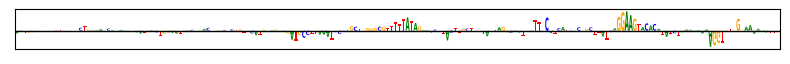

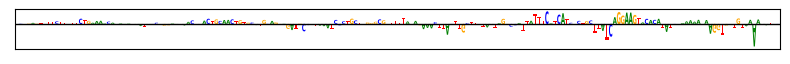

brain


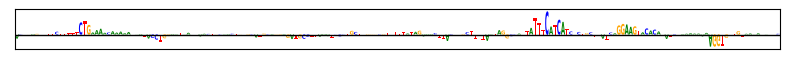

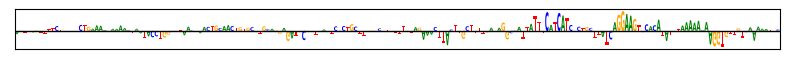

esophagus


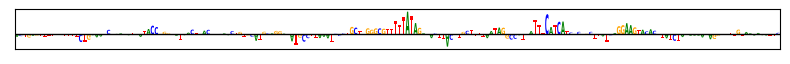

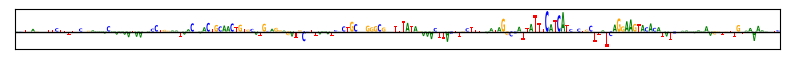

liver


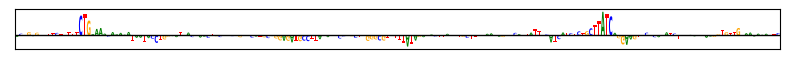

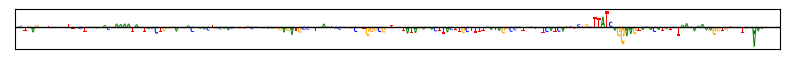

muscle


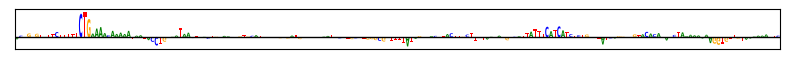

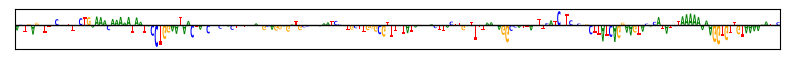

--------------------

-- Example = 41 --
 - ENSG00000166527(+)
 - chr12:8257745-8782033
blood (r = 0.674)
brain (r = 0.67)
esophagus (r = 0.669)
liver (r = 0.672)
muscle (r = 0.666)


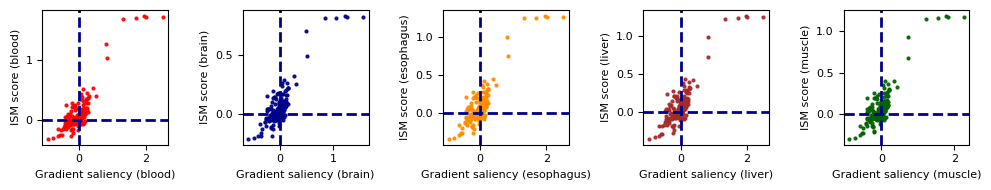

blood


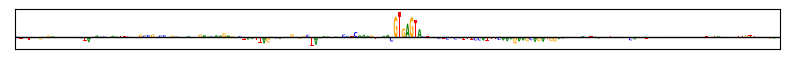

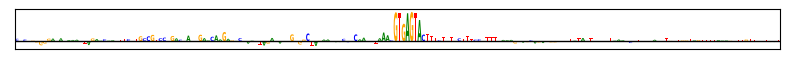

brain


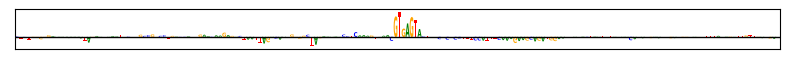

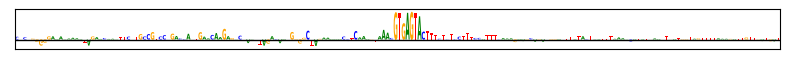

esophagus


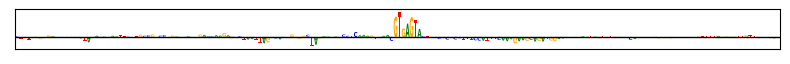

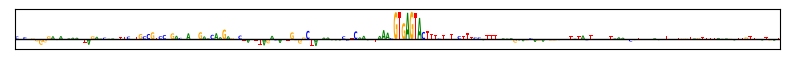

liver


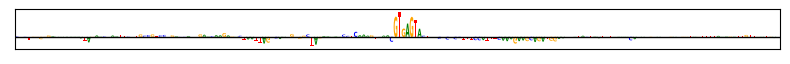

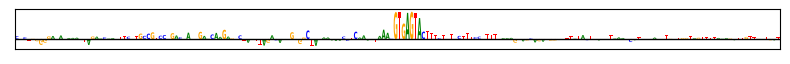

muscle


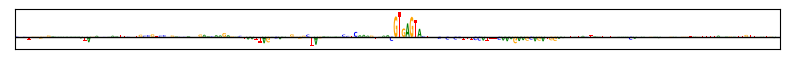

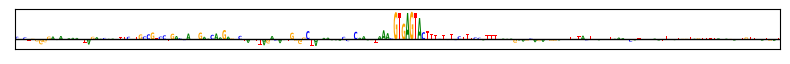

--------------------

-- Example = 42 --
 - ENSG00000163736(-)
 - chr4:73725041-74249329
blood (r = 0.752)
brain (r = 0.669)
esophagus (r = 0.71)
liver (r = 0.707)
muscle (r = 0.682)


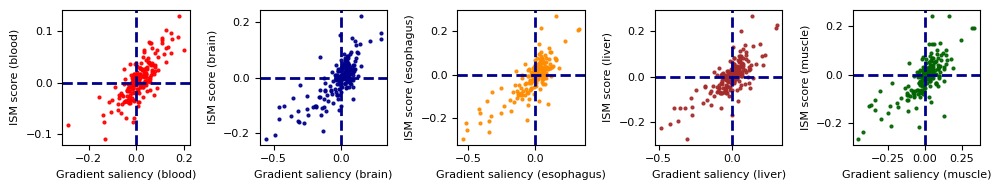

blood


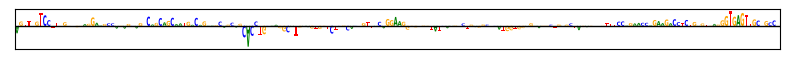

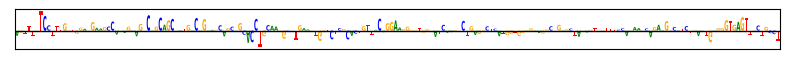

brain


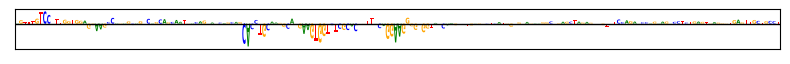

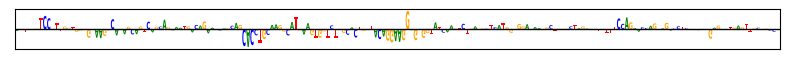

esophagus


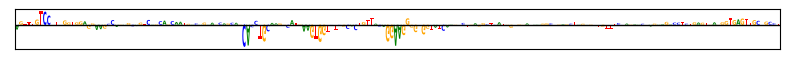

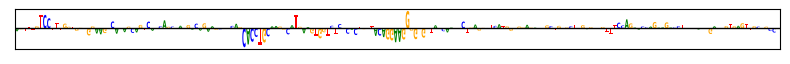

liver


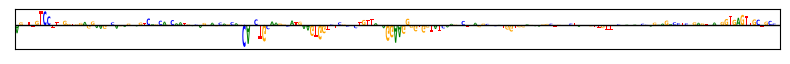

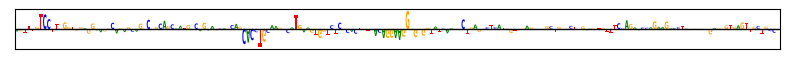

muscle


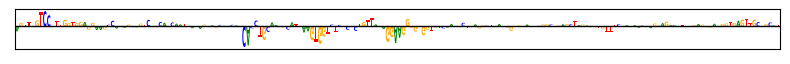

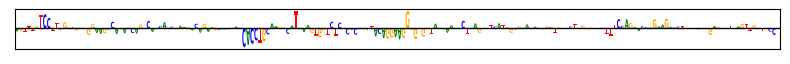

--------------------

-- Example = 43 --
 - ENSG00000180549(-)
 - chr9:136768876-137293164
blood (r = 0.806)
brain (r = 0.643)
esophagus (r = 0.777)
liver (r = 0.721)
muscle (r = 0.797)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


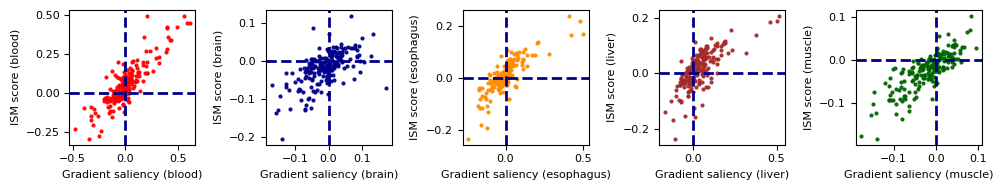

blood


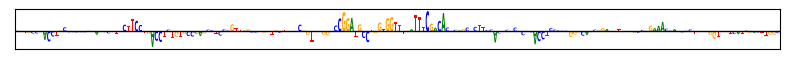

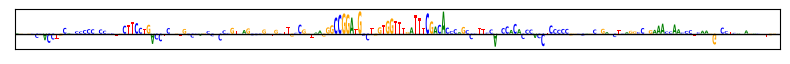

brain


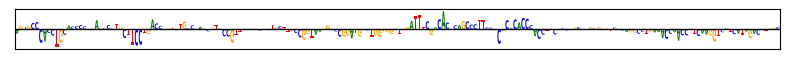

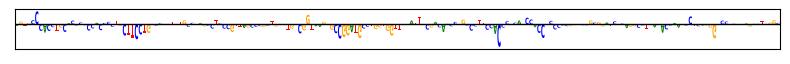

esophagus


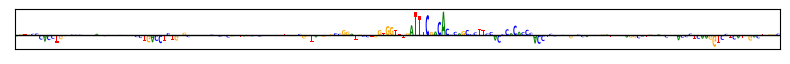

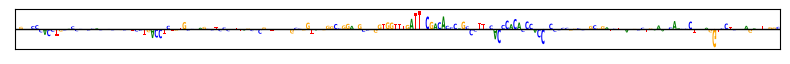

liver


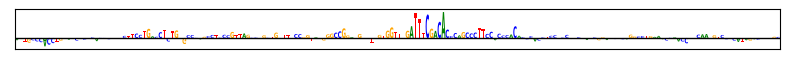

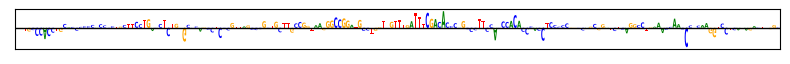

muscle


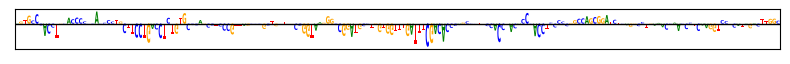

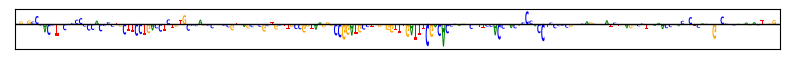

--------------------

-- Example = 44 --
 - ENSG00000100985(+)
 - chr20:45750380-46274668
blood (r = 0.683)
brain (r = 0.39)
esophagus (r = 0.518)
liver (r = 0.608)
muscle (r = 0.449)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


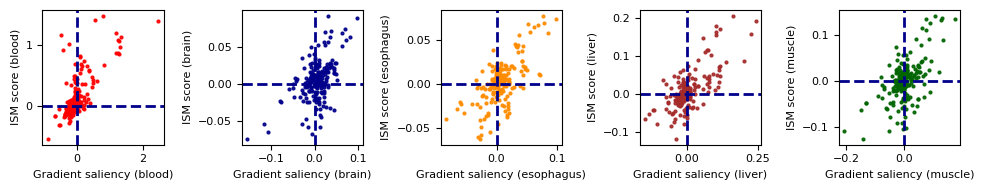

blood


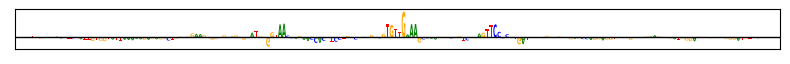

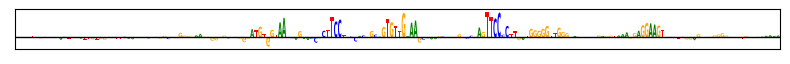

brain


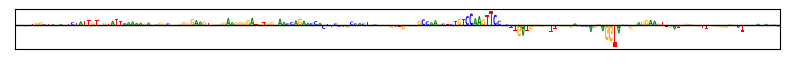

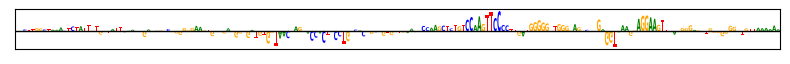

esophagus


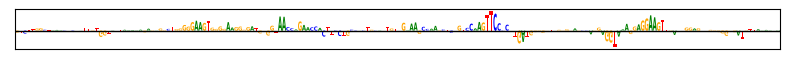

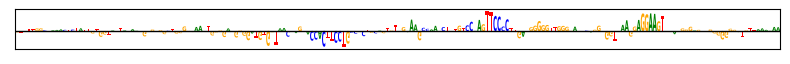

liver


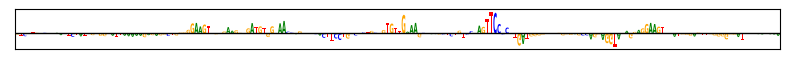

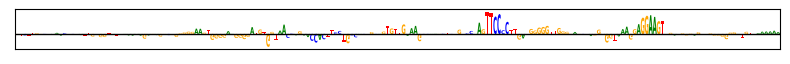

muscle


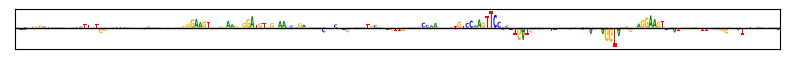

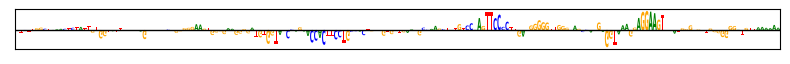

--------------------

-- Example = 45 --
 - ENSG00000076662(-)
 - chr19:10073518-10597806
blood (r = 0.793)
brain (r = 0.715)
esophagus (r = 0.823)
liver (r = 0.766)
muscle (r = 0.839)


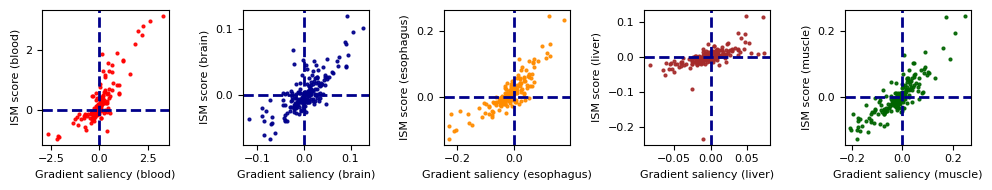

blood


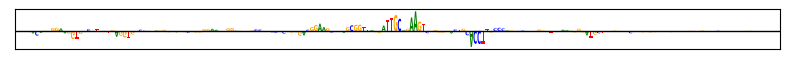

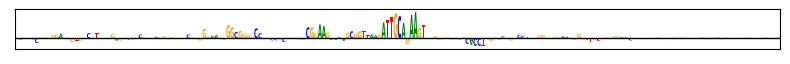

brain


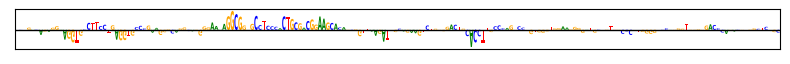

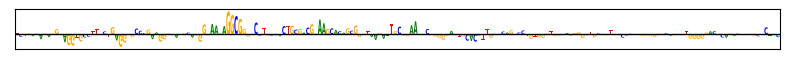

esophagus


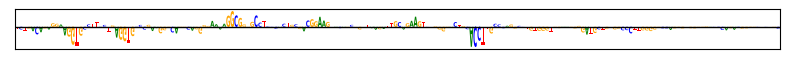

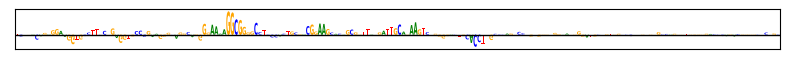

liver


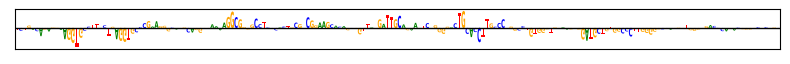

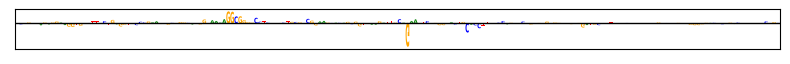

muscle


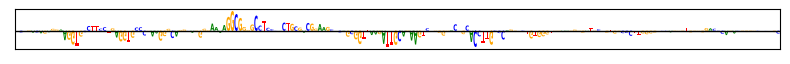

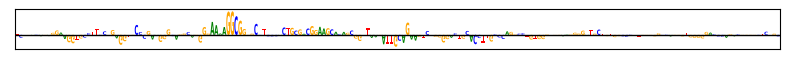

--------------------

-- Example = 46 --
 - ENSG00000142405(-)
 - chr19:53545852-54070140
blood (r = 0.79)
brain (r = 0.621)
esophagus (r = 0.677)
liver (r = 0.657)
muscle (r = 0.694)


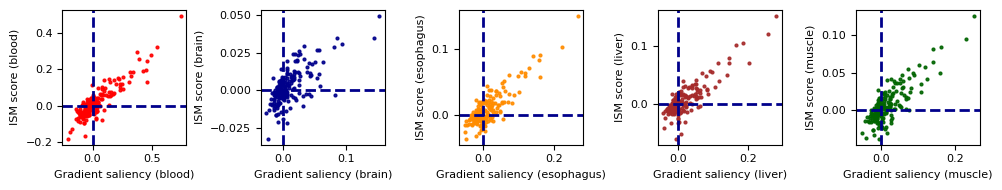

blood


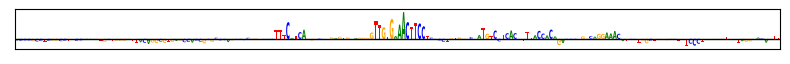

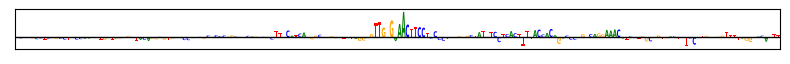

brain


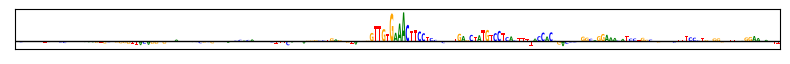

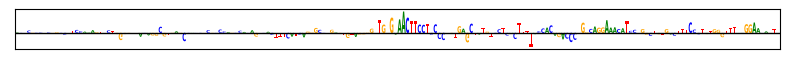

esophagus


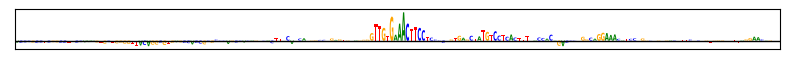

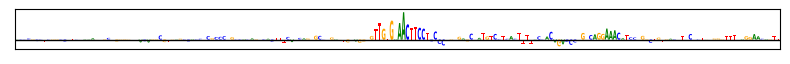

liver


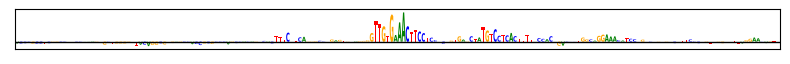

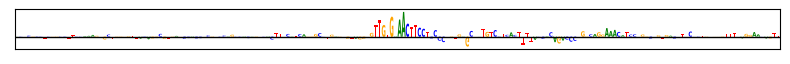

muscle


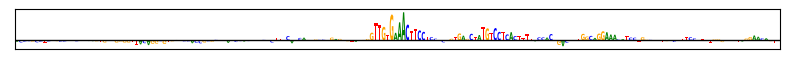

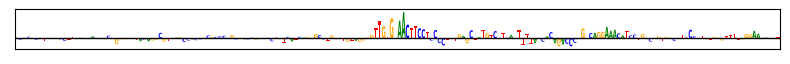

--------------------

-- Example = 47 --
 - ENSG00000169704(+)
 - chr3:128799745-129324033
blood (r = 0.799)
brain (r = 0.724)
esophagus (r = 0.759)
liver (r = 0.752)
muscle (r = 0.778)


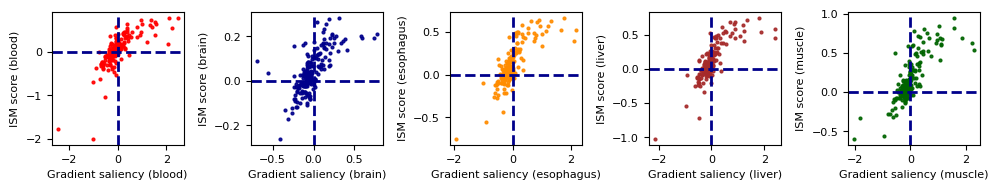

blood


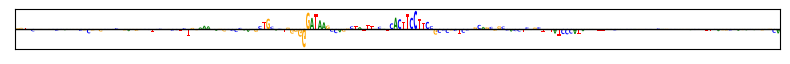

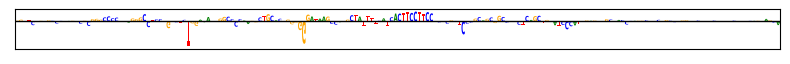

brain


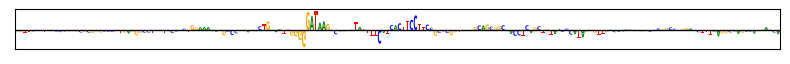

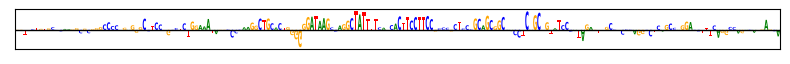

esophagus


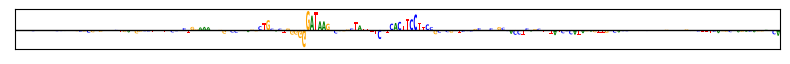

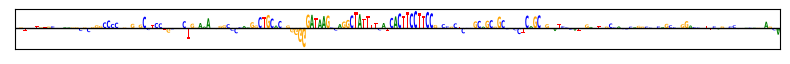

liver


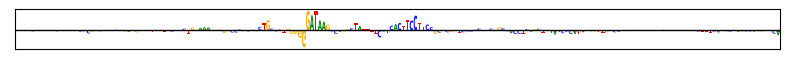

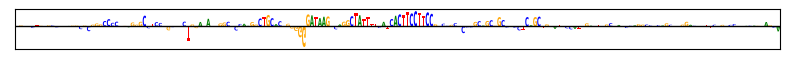

muscle


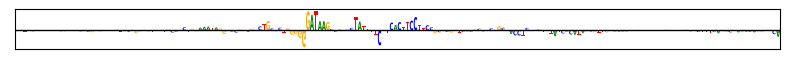

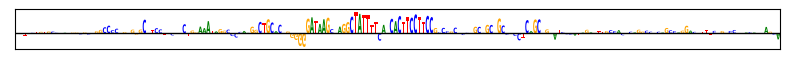

--------------------

-- Example = 48 --
 - ENSG00000239998(+)
 - chr19:54322467-54846755
blood (r = 0.668)
brain (r = 0.759)
esophagus (r = 0.684)
liver (r = 0.614)
muscle (r = 0.636)


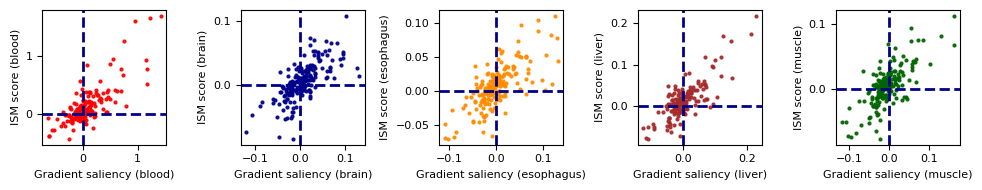

blood


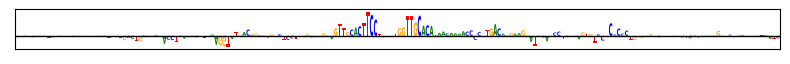

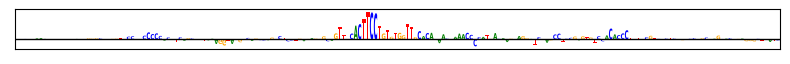

brain


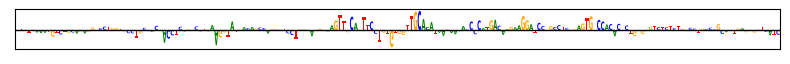

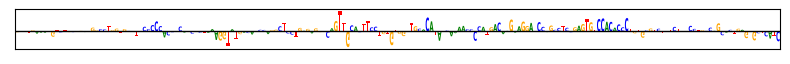

esophagus


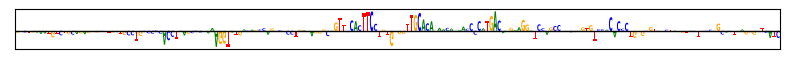

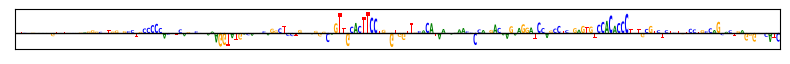

liver


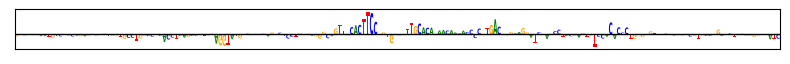

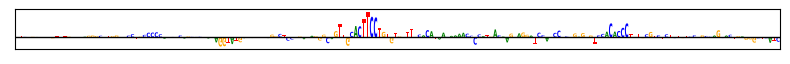

muscle


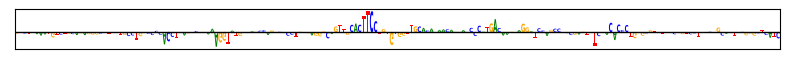

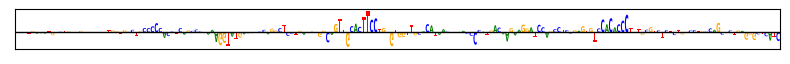

--------------------

-- Example = 49 --
 - ENSG00000174837(+)
 - chr19:6655798-7180086
blood (r = 0.773)
brain (r = 0.758)
esophagus (r = 0.776)
liver (r = 0.743)
muscle (r = 0.754)


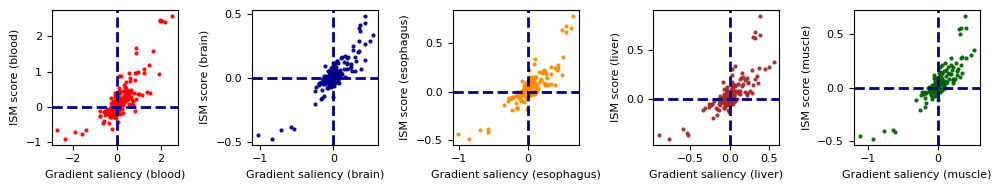

blood


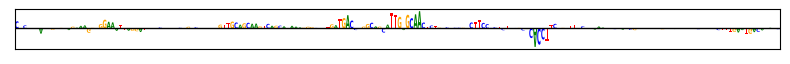

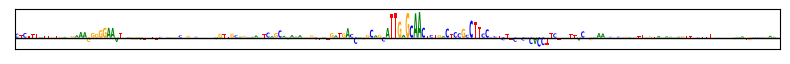

brain


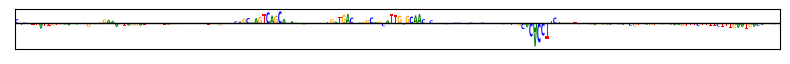

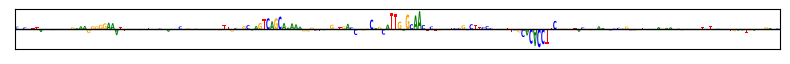

esophagus


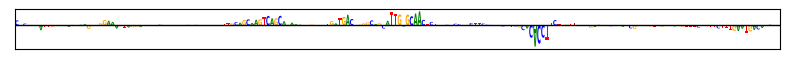

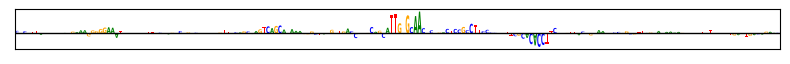

liver


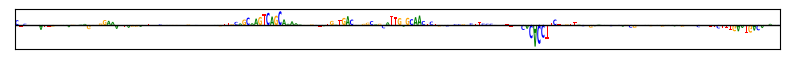

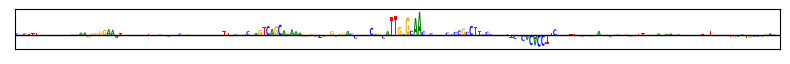

muscle


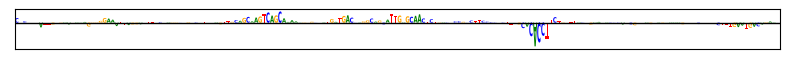

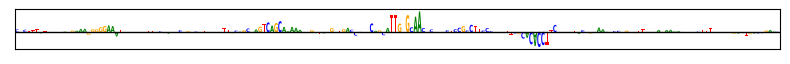

--------------------



In [8]:
#Enumerate and visualize attributions (relative fold changes); blood

save_figs = True
save_prefix = 'attribution_figs/borzoi_v2_diff_expr_grads_vs_isms_5_tissues_4_folds_' + tissue

save_index = [3, 17, 37, 43, 44]

top_n = 50

tissue_colors = ['red', 'darkblue', 'darkorange', 'brown', 'darkgreen']

r_vals = np.zeros((scores.shape[1], scores.shape[0]))

#Loop over examples
for example_ix in range(scores.shape[1]) :
    
    #Calculate spearman correlation between grad and ISM values
    for tissue_ix in range(len(gtex_tissues)) :
        r_vals[example_ix, tissue_ix] = spearmanr(
            np.sum(scores[tissue_ix, example_ix, ...], axis=-1),
            np.sum(isms[tissue_ix, example_ix, ...], axis=-1),
        )[0]
    
    #Visualize example
    if example_ix < top_n :
        
        print("-- Example = " + str(example_ix)+ " --")
    
        save_figs_curr = False
        if save_figs and example_ix in set(save_index) :
            save_figs_curr = True

        print(" - " + tissue_genes[example_ix] + "(" + str(strands[example_ix]) + ")")
        print(" - " + chrs[example_ix] + ":" + str(starts[example_ix]) + "-" + str(ends[example_ix]))
        
        #Scatter plots of gradient vs ISM scores
        f, ax = plt.subplots(1, len(gtex_tissues), figsize=(len(gtex_tissues) * 2, 2))

        #Compare contribution scores
        for tissue_ix in range(len(gtex_tissues)) :

            #Gradient saliencies and ISM scores
            score = scores[tissue_ix, example_ix, ...]
            ism = isms[tissue_ix, example_ix, ...]
            
            #Print stats
            print(gtex_tissues[tissue_ix] + " (r = " + str(round(r_vals[example_ix, tissue_ix], 3)) + ")")

            #Scatter plot of scores
            ax[tissue_ix].scatter(np.sum(score, axis=-1), np.sum(ism, axis=-1), s=4, color=tissue_colors[tissue_ix], alpha=0.9)

            plt.sca(ax[tissue_ix])
            
            plt.axhline(y=0, linewidth=2, linestyle='--', color='darkblue')
            plt.axvline(x=0, linewidth=2, linestyle='--', color='darkblue')

            plt.xticks(fontsize=8)
            plt.yticks(fontsize=8)

            plt.xlabel("Gradient saliency (" + gtex_tissues[tissue_ix] + ")", fontsize=8)
            plt.ylabel("ISM score (" + gtex_tissues[tissue_ix] + ")", fontsize=8)

        plt.sca(plt.gca())
        plt.tight_layout()

        if save_figs_curr :
            plt.savefig(save_prefix + '_scatters_example_ix_' + str(example_ix) + ".png", dpi=300, transparent=False)
            plt.savefig(save_prefix + '_scatters_example_ix_' + str(example_ix) + ".eps")

        plt.show()
        
        #Visualize contribution scores
        
        #Loop over tissues
        for tissue_ix in range(len(gtex_tissues)) :
            print(gtex_tissues[tissue_ix])

            #Get tissue-specific scores
            score = scores[tissue_ix, example_ix, :, :]
            ism = isms[tissue_ix, example_ix, :, :]

            #Plot scores as sequence logo
            plot_seq_scores(
                score,
                figsize=(8, 0.75),
                plot_y_ticks=False,
                save_figs=save_figs_curr,
                fig_name=save_prefix + '_logo_example_ix_' + str(example_ix) + '_tissue_ix_' + str(tissue_ix) + '_grad',
            )

            #Plot ISM as sequence logo
            plot_seq_scores(
                ism,
                figsize=(8, 0.75),
                plot_y_ticks=False,
                save_figs=save_figs_curr,
                fig_name=save_prefix + '_logo_example_ix_' + str(example_ix) + '_tissue_ix_' + str(tissue_ix) + '_ism',
            )
        
        print("--------------------")
        print("")


blood median r = 0.72
brain median r = 0.7
esophagus median r = 0.71
liver median r = 0.69
muscle median r = 0.71


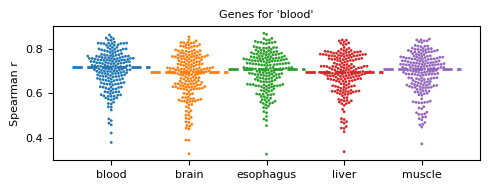

In [9]:
#Visualize tissue-specific distributions of contribution score correlations (grad vs. ISM)

f = plt.figure(figsize=(1 * len(gtex_tissues), 2))

sns.swarmplot(data=r_vals.T.tolist(), s=2)

#Loop over tissues
for tissue_i, gtex_tissue in enumerate(gtex_tissues) :
    
    median_r = np.median(r_vals[:, tissue_i])
    print(gtex_tissue + " median r = " + str(round(median_r, 2)))
    
    plt.plot([tissue_i - 0.5, tissue_i + 0.5], [median_r, median_r], linestyle='--', linewidth=2)

plt.xticks(np.arange(len(gtex_tissues)), gtex_tissues, fontsize=8)
plt.yticks(fontsize=8)

plt.ylabel("Spearman r", fontsize=8)

plt.ylim(0.3, 0.9)

plt.title("Genes for '" + tissue + "'", fontsize=8)

plt.tight_layout()

if save_figs :
    plt.savefig(save_prefix + "_corrs" + ".eps")
    plt.savefig(save_prefix + "_corrs" + ".png", dpi=300, transparent=False)

plt.show()


-- Example = 3 --
 - ENSG00000110203(+)
 - chr11:71876423-72400711
blood (r = 0.704)
brain (r = 0.711)
esophagus (r = 0.737)
liver (r = 0.678)
muscle (r = 0.703)


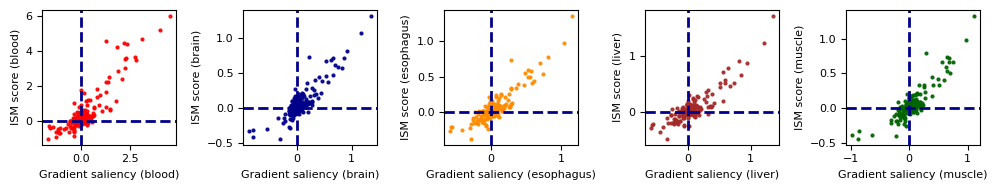

blood
 - y_min = -2.16171875
 - y_max = 5.04453125


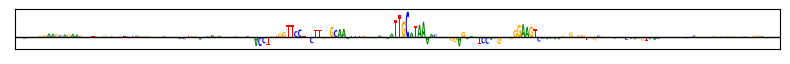

 - y_min = -1.62148438
 - y_max = 6.6


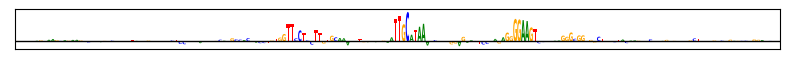

brain
 - y_min = -1.01728516
 - y_max = 1.4953125


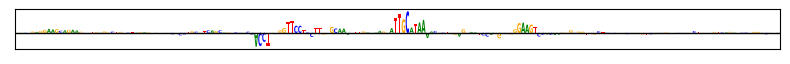

 - y_min = -0.56547852
 - y_max = 1.43730469


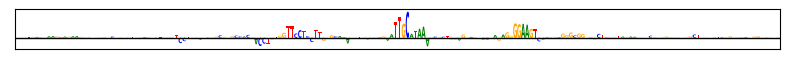

esophagus
 - y_min = -0.69111328
 - y_max = 1.26972656


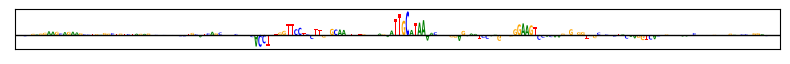

 - y_min = -0.50522461
 - y_max = 1.48886719


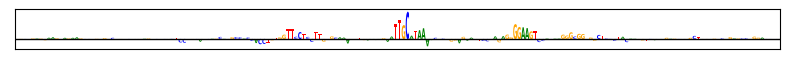

liver
 - y_min = -0.71992188
 - y_max = 1.48994141


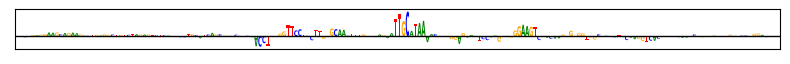

 - y_min = -0.63569336
 - y_max = 1.88203125


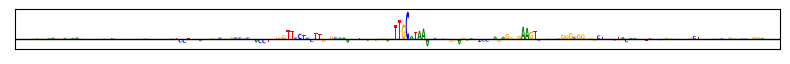

muscle
 - y_min = -1.08447266
 - y_max = 1.21923828


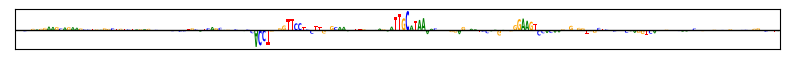

 - y_min = -0.57143555
 - y_max = 1.45449219


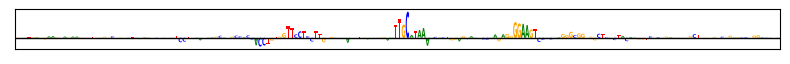

--------------------



In [8]:
#Enumerate and visualize attributions (relative fold changes); blood

save_figs = False
save_prefix = 'attribution_figs/borzoi_v2_diff_expr_grads_vs_isms_5_tissues_4_folds_' + tissue

save_index = [3]

top_n = 50

tissue_colors = ['red', 'darkblue', 'darkorange', 'brown', 'darkgreen']

r_vals = np.zeros((scores.shape[1], scores.shape[0]))

#Loop over examples
for example_ix in range(3, 4) :
    
    #Calculate spearman correlation between grad and ISM values
    for tissue_ix in range(len(gtex_tissues)) :
        r_vals[example_ix, tissue_ix] = spearmanr(
            np.sum(scores[tissue_ix, example_ix, ...], axis=-1),
            np.sum(isms[tissue_ix, example_ix, ...], axis=-1),
        )[0]
    
    #Visualize example
    if example_ix < top_n :
        
        print("-- Example = " + str(example_ix)+ " --")
    
        save_figs_curr = False
        if save_figs and example_ix in set(save_index) :
            save_figs_curr = True

        print(" - " + tissue_genes[example_ix] + "(" + str(strands[example_ix]) + ")")
        print(" - " + chrs[example_ix] + ":" + str(starts[example_ix]) + "-" + str(ends[example_ix]))
        
        #Scatter plots of gradient vs ISM scores
        f, ax = plt.subplots(1, len(gtex_tissues), figsize=(len(gtex_tissues) * 2, 2))

        #Compare contribution scores
        for tissue_ix in range(len(gtex_tissues)) :

            #Gradient saliencies and ISM scores
            score = scores[tissue_ix, example_ix, ...]
            ism = isms[tissue_ix, example_ix, ...]
            
            #Print stats
            print(gtex_tissues[tissue_ix] + " (r = " + str(round(r_vals[example_ix, tissue_ix], 3)) + ")")

            #Scatter plot of scores
            ax[tissue_ix].scatter(np.sum(score, axis=-1), np.sum(ism, axis=-1), s=4, color=tissue_colors[tissue_ix], alpha=0.9)

            plt.sca(ax[tissue_ix])
            
            plt.axhline(y=0, linewidth=2, linestyle='--', color='darkblue')
            plt.axvline(x=0, linewidth=2, linestyle='--', color='darkblue')

            plt.xticks(fontsize=8)
            plt.yticks(fontsize=8)

            plt.xlabel("Gradient saliency (" + gtex_tissues[tissue_ix] + ")", fontsize=8)
            plt.ylabel("ISM score (" + gtex_tissues[tissue_ix] + ")", fontsize=8)

        plt.sca(plt.gca())
        plt.tight_layout()

        if save_figs_curr :
            plt.savefig(save_prefix + '_scatters_example_ix_' + str(example_ix) + ".png", dpi=300, transparent=False)
            plt.savefig(save_prefix + '_scatters_example_ix_' + str(example_ix) + ".eps")

        plt.show()
        
        #Visualize contribution scores
        
        #Loop over tissues
        for tissue_ix in range(len(gtex_tissues)) :
            print(gtex_tissues[tissue_ix])

            #Get tissue-specific scores
            score = scores[tissue_ix, example_ix, :, :]
            ism = isms[tissue_ix, example_ix, :, :]

            #Plot scores as sequence logo
            plot_seq_scores(
                score,
                figsize=(8, 0.75),
                plot_y_ticks=False,
                save_figs=save_figs_curr,
                fig_name=save_prefix + '_logo_example_ix_' + str(example_ix) + '_tissue_ix_' + str(tissue_ix) + '_grad',
            )

            #Plot ISM as sequence logo
            plot_seq_scores(
                ism,
                figsize=(8, 0.75),
                plot_y_ticks=False,
                save_figs=save_figs_curr,
                fig_name=save_prefix + '_logo_example_ix_' + str(example_ix) + '_tissue_ix_' + str(tissue_ix) + '_ism',
            )
        
        print("--------------------")
        print("")
